In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import pickle
import seaborn as sns
from sqlalchemy import create_engine
%matplotlib inline

In [226]:
# READING TURNSTILE DATASET FROM MTA
path = '/Users/mohamad/Desktop/MTA_PROJECT/Turnstile_Usage_Data__2018.csv'
col_name_new = ['C/A','UNIT','SCP','STATION','LINENAME','DIVISION','DATE','TIME','DESC','ENTRIES','EXITS']
MTA_data_2018 = pd.read_csv(path, sep=",", header=0, names = col_name_new)

In [480]:
# READING THE ARRESTS ASSIGNED (AT EVERY STATION) DATASET 

path = 'https://raw.githubusercontent.com/NickRothbacher/nyc-fare-evasion/master/data/arrests_and_turns.csv'
col_name_new = ['ARREST_KEY','ARREST_DATE','ARREST__BORO','JURISDICTION_CODE','ARREST_PRECINCT','AGE_GROUP','PERP_SEX','PERP_RACE','Latitude','Longitude','geometry',
                 'line','name','notes','objectid','ENTRIES','EXITS']
ARRESTASSIGNED = pd.read_csv(path, sep=",", header=0, names = col_name_new)

In [481]:
# STRIPPING THE WHITE SPACES
MTA_data_2018.columns = [column.strip() for column in MTA_data_2018.columns]
# ARREST DATASETS
ARRESTASSIGNED.columns = [column.strip() for column in ARRESTASSIGNED.columns]

In [33]:
#ADDING A NEW COLUMN TO COMBINE THE DATE AND TIME
MTA_data_2018["DATE_TIME"] = pd.to_datetime(MTA_data_2018.DATE + " " + MTA_data_2018.TIME, format="%m/%d/%Y %H:%M:%S")

In [34]:
# THE READINGS IN EACH DAY THROUGHOUT THE YEAR
MTA_data_2018.DATE.value_counts().sort_index()

01/01/2018    28157
01/02/2018    28103
01/03/2018    28104
01/04/2018    31032
01/05/2018    28987
              ...  
12/28/2017    28237
12/28/2018    59186
12/29/2017    27890
12/30/2017    28206
12/31/2017    28076
Name: DATE, Length: 350, dtype: int64

In [35]:
#FOR IDENTIFYING UNIQUE TURNSTILES
MTA_data_2018['TURNSTILE'] = MTA_data_2018['C/A'] + '-' + MTA_data_2018['UNIT'] + '-' + MTA_data_2018['SCP']+ '-' + MTA_data_2018['STATION']

In [36]:
MTA_data_2018.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,TURNSTILE
0,A033,R170,02-00-04,14 ST-UNION SQ,LNQR456W,BMT,12/28/2018,00:00:00,REGULAR,4927946,3748371,2018-12-28,A033-R170-02-00-04-14 ST-UNION SQ
1,A033,R170,02-00-05,14 ST-UNION SQ,LNQR456W,BMT,12/28/2018,00:00:00,REGULAR,15598097,6250334,2018-12-28,A033-R170-02-00-05-14 ST-UNION SQ
2,A033,R170,02-00-05,14 ST-UNION SQ,LNQR456W,BMT,12/28/2018,00:00:00,REGULAR,15598097,6250334,2018-12-28,A033-R170-02-00-05-14 ST-UNION SQ
3,A033,R170,02-06-01,14 ST-UNION SQ,LNQR456W,BMT,12/28/2018,00:00:00,REGULAR,70294362,20274025,2018-12-28,A033-R170-02-06-01-14 ST-UNION SQ
4,A033,R170,02-00-01,14 ST-UNION SQ,LNQR456W,BMT,12/28/2018,00:00:00,REGULAR,1806541,2182381,2018-12-28,A033-R170-02-00-01-14 ST-UNION SQ


In [37]:
# SANITY CHECK
(MTA_data_2018.groupby(['TURNSTILE','DATE_TIME']).ENTRIES.count().reset_index().sort_values("ENTRIES", ascending=False)).head(5)

,TURNSTILE,DATE_TIME,ENTRIES
9910224,TRAM2-R469-00-05-01-RIT-ROOSEVELT,2018-12-28 20:00:00,2
4180335,N333B-R141-02-00-03-FOREST HILLS 71,2018-12-27 12:00:00,2
7616151,R237-R046-01-00-05-GRD CNTRL-42 ST,2018-12-28 03:00:00,2
7616152,R237-R046-01-00-05-GRD CNTRL-42 ST,2018-12-28 07:00:00,2
7616153,R237-R046-01-00-05-GRD CNTRL-42 ST,2018-12-28 11:00:00,2


In [38]:
# GET RID OF DUPLICATES
MTA_data_2018.sort_values(['TURNSTILE', "DATE_TIME"], 
                          inplace=True, ascending=False)
MTA_data_2018.drop_duplicates(subset=["TURNSTILE", "DATE_TIME"], inplace=True)

In [39]:
# SANITY CHECK TO ENSURE THE DELETION OF DUPLICATES
(MTA_data_2018.groupby(['TURNSTILE','DATE_TIME']).ENTRIES.count().reset_index().sort_values("ENTRIES", ascending=False)).head(5)

,TURNSTILE,DATE_TIME,ENTRIES
0,A002-R051-02-00-00-59 ST,2017-12-23 03:00:00,1
6606812,R143-R032-02-00-01-TIMES SQ-42 ST,2018-08-12 08:00:00,1
6606814,R143-R032-02-00-01-TIMES SQ-42 ST,2018-08-12 16:00:00,1
6606815,R143-R032-02-00-01-TIMES SQ-42 ST,2018-08-12 20:00:00,1
6606816,R143-R032-02-00-01-TIMES SQ-42 ST,2018-08-13 00:00:00,1


In [40]:
MTA_data_2018.DESC.value_counts()

REGULAR       9867783
RECOVR AUD      42442
Name: DESC, dtype: int64

In [41]:
# NEGLECTING THE MALFUNCTIONING TURNSTILES
MTA_data_2018 = pd.DataFrame(MTA_data_2018[MTA_data_2018.DESC == 'REGULAR'])

In [42]:
MTA_data_2018.DESC.value_counts()

REGULAR    9867783
Name: DESC, dtype: int64

In [43]:
# DROPPING THE UNNECCESARY COLUMNS LIKE EXITS , DESCRIBTION , LINENAME AND DIVISION
MTA_data_2018 = MTA_data_2018.drop(["EXITS", "DESC",'LINENAME','DIVISION'], axis=1, errors="ignore")

In [44]:
MTA_data_2018.sort_values(['TURNSTILE', "DATE"], inplace=True, ascending=True)

In [45]:
MTA_data_2018.head()

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,DATE_TIME,TURNSTILE
9855431,A002,R051,02-00-00,59 ST,01/01/2018,23:00:00,6464907,2018-01-01 23:00:00,A002-R051-02-00-00-59 ST
9850756,A002,R051,02-00-00,59 ST,01/01/2018,19:00:00,6464806,2018-01-01 19:00:00,A002-R051-02-00-00-59 ST
9846063,A002,R051,02-00-00,59 ST,01/01/2018,15:00:00,6464623,2018-01-01 15:00:00,A002-R051-02-00-00-59 ST
9841353,A002,R051,02-00-00,59 ST,01/01/2018,11:00:00,6464517,2018-01-01 11:00:00,A002-R051-02-00-00-59 ST
9836613,A002,R051,02-00-00,59 ST,01/01/2018,07:00:00,6464491,2018-01-01 07:00:00,A002-R051-02-00-00-59 ST


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ENTRIES'>

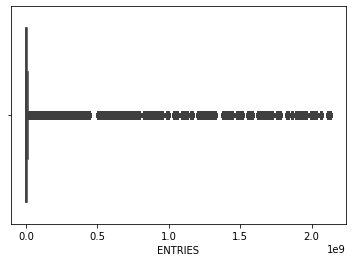

In [46]:
# CHECKING FOR OUTLIERS
sns.boxplot(MTA_data_2018.ENTRIES)

<AxesSubplot:title={'center':'ENTRIES'}, xlabel='[STATION]'>

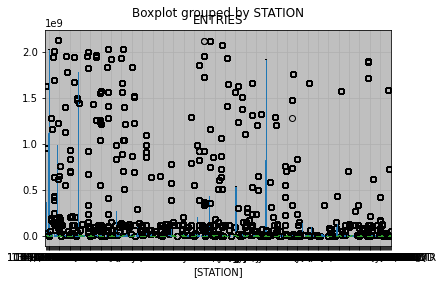

In [47]:
MTA_data_2018.boxplot(by='STATION')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'cumulative probability distribution of entries'}, xlabel='ENTRIES', ylabel='Density'>

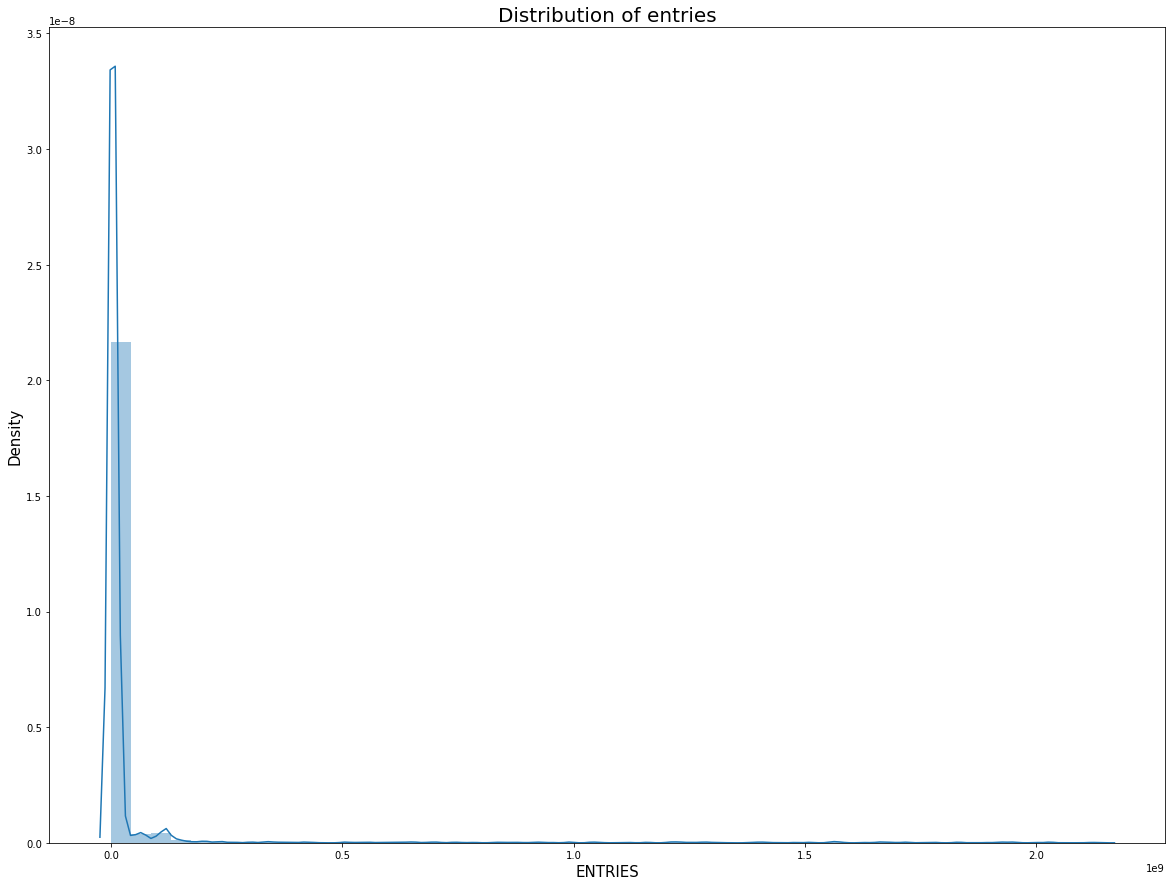

<Figure size 432x288 with 0 Axes>

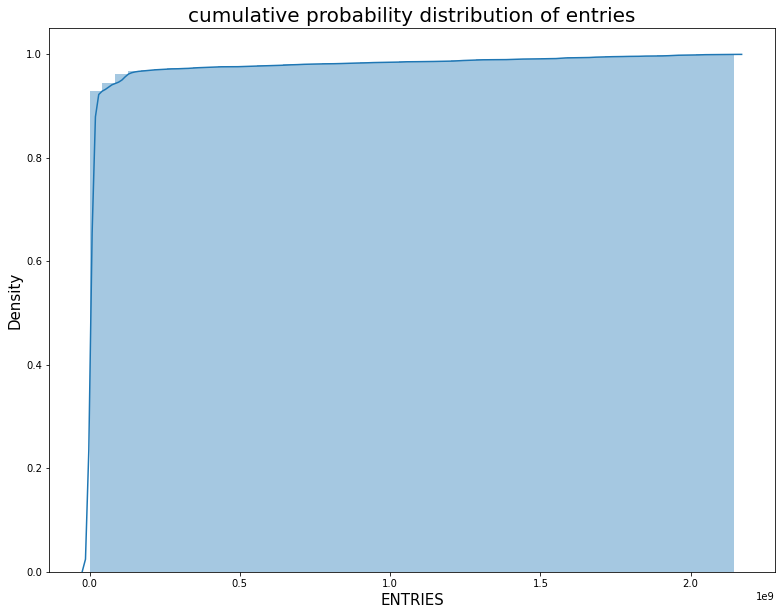

In [713]:
plt.figure(figsize=(20,15))
plt.title("Distribution of entries", fontsize=20);
plt.xlabel("Entries", fontsize=15)
plt.ylabel("Density", fontsize=15)
sns.distplot(MTA_data_2018.ENTRIES)
plt.savefig('graph000.png')

plt.figure()

plt.figure(figsize=(13,10))
plt.title("cumulative probability distribution of entries", fontsize=20);
plt.xlabel("Entries", fontsize=15)
plt.ylabel("Density", fontsize=15)
sns.distplot(MTA_data_2018.ENTRIES,hist_kws={"cumulative":True},kde_kws={"cumulative":True})


In [49]:
# OUTLIERS
q3 = MTA_data_2018.ENTRIES.quantile(q=0.75)
q1 = MTA_data_2018.ENTRIES.quantile(q=0.25)
IQR = q3 -  q1
OUTLIER = q3 + 1.5 * IQR
OUTLIER

16550368.25

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ENTRIES'>

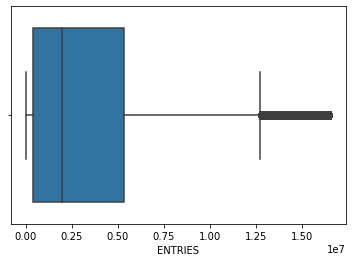

In [50]:
sns.boxplot( MTA_data_2018[MTA_data_2018.ENTRIES<=OUTLIER].ENTRIES)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'cumulative probability distribution of entries'}, xlabel='ENTRIES', ylabel='Density'>

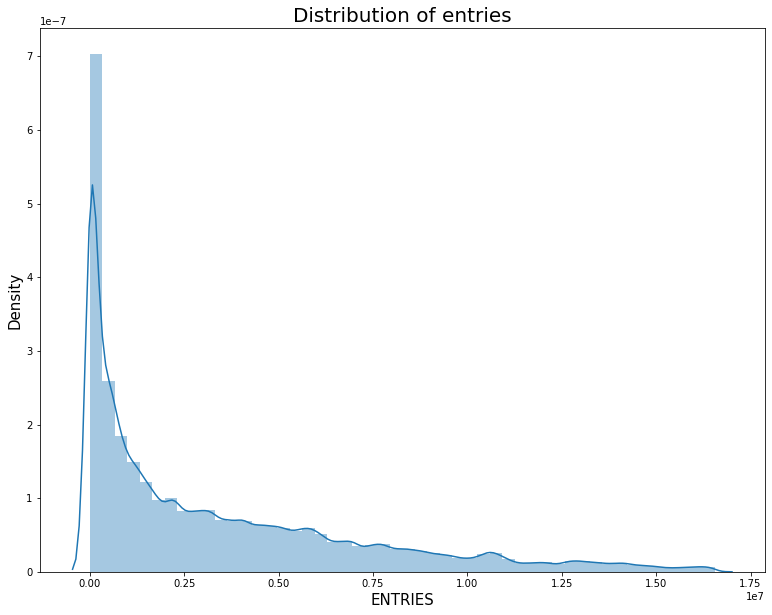

<Figure size 432x288 with 0 Axes>

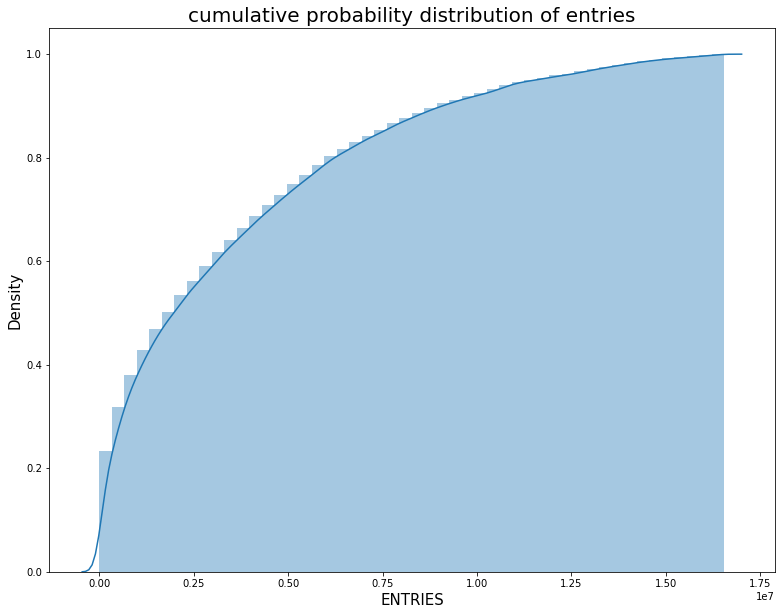

In [712]:

plt.figure(figsize=(13,10))
plt.title("Distribution of entries", fontsize=20);
plt.xlabel("Entries", fontsize=15)
plt.ylabel("Density", fontsize=15)
sns.distplot(MTA_data_2018.ENTRIES[MTA_data_2018.ENTRIES<=OUTLIER])
plt.savefig('graph0001.png')
plt.figure()

plt.figure(figsize=(13,10))
plt.title("cumulative probability distribution of entries", fontsize=20);
plt.xlabel("Entries", fontsize=15)
plt.ylabel("Density", fontsize=15)
sns.distplot(MTA_data_2018.ENTRIES[MTA_data_2018.ENTRIES<=OUTLIER],hist_kws={"cumulative":True},kde_kws={"cumulative":True})


In [52]:
#REMOVING THE OUTLIERS
MTA_data_2018 = MTA_data_2018[(MTA_data_2018.ENTRIES<=OUTLIER)]

In [53]:
MTA_data_2018.head()

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,DATE_TIME,TURNSTILE
9855431,A002,R051,02-00-00,59 ST,01/01/2018,23:00:00,6464907,2018-01-01 23:00:00,A002-R051-02-00-00-59 ST
9850756,A002,R051,02-00-00,59 ST,01/01/2018,19:00:00,6464806,2018-01-01 19:00:00,A002-R051-02-00-00-59 ST
9846063,A002,R051,02-00-00,59 ST,01/01/2018,15:00:00,6464623,2018-01-01 15:00:00,A002-R051-02-00-00-59 ST
9841353,A002,R051,02-00-00,59 ST,01/01/2018,11:00:00,6464517,2018-01-01 11:00:00,A002-R051-02-00-00-59 ST
9836613,A002,R051,02-00-00,59 ST,01/01/2018,07:00:00,6464491,2018-01-01 07:00:00,A002-R051-02-00-00-59 ST


In [54]:
# STORING THE TURNSTILES WITH THE MOST ENTRIES IN EACH STATION DESCENDINGLY (CUMMULATIVE)
TURNSTILE_DAILY = (MTA_data_2018
                        .groupby(['TURNSTILE', "DATE",'STATION'],as_index=False)
                        .ENTRIES.first())

In [55]:
# SPLITTING THE GROUP BY TO LATER ON FILTER ON SCP
TURNSTILE_DAILY_NOSCP = (MTA_data_2018
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())

In [56]:
TURNSTILE_DAILY_NOSCP

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,01/01/2018,6464907
1,A002,R051,02-00-00,59 ST,01/02/2018,6466375
2,A002,R051,02-00-00,59 ST,01/03/2018,6467957
3,A002,R051,02-00-00,59 ST,01/04/2018,6468797
4,A002,R051,02-00-00,59 ST,01/05/2018,6470180
...,...,...,...,...,...,...
1488082,TRAM2,R469,00-05-01,RIT-ROOSEVELT,12/24/2018,5554
1488083,TRAM2,R469,00-05-01,RIT-ROOSEVELT,12/25/2018,5554
1488084,TRAM2,R469,00-05-01,RIT-ROOSEVELT,12/26/2018,5554
1488085,TRAM2,R469,00-05-01,RIT-ROOSEVELT,12/27/2018,5554


In [57]:
TURNSTILE_DAILY

,TURNSTILE,DATE,STATION,ENTRIES
0,A002-R051-02-00-00-59 ST,01/01/2018,59 ST,6464907
1,A002-R051-02-00-00-59 ST,01/02/2018,59 ST,6466375
2,A002-R051-02-00-00-59 ST,01/03/2018,59 ST,6467957
3,A002-R051-02-00-00-59 ST,01/04/2018,59 ST,6468797
4,A002-R051-02-00-00-59 ST,01/05/2018,59 ST,6470180
...,...,...,...,...
1488082,TRAM2-R469-00-05-01-RIT-ROOSEVELT,12/24/2018,RIT-ROOSEVELT,5554
1488083,TRAM2-R469-00-05-01-RIT-ROOSEVELT,12/25/2018,RIT-ROOSEVELT,5554
1488084,TRAM2-R469-00-05-01-RIT-ROOSEVELT,12/26/2018,RIT-ROOSEVELT,5554
1488085,TRAM2-R469-00-05-01-RIT-ROOSEVELT,12/27/2018,RIT-ROOSEVELT,5554


In [58]:
TURNSTILE_DAILY_NOSCP[["PREV_DATE", "PREV_ENTRIES"]] = (TURNSTILE_DAILY_NOSCP
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

<ipython-input-58-5387b4f6d138>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  TURNSTILE_DAILY_NOSCP[["PREV_DATE", "PREV_ENTRIES"]] = (TURNSTILE_DAILY_NOSCP


In [59]:
TURNSTILE_DAILY_NOSCP

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,01/01/2018,6464907,NaN,NaN
1,A002,R051,02-00-00,59 ST,01/02/2018,6466375,01/01/2018,6464907.0
2,A002,R051,02-00-00,59 ST,01/03/2018,6467957,01/02/2018,6466375.0
3,A002,R051,02-00-00,59 ST,01/04/2018,6468797,01/03/2018,6467957.0
4,A002,R051,02-00-00,59 ST,01/05/2018,6470180,01/04/2018,6468797.0
...,...,...,...,...,...,...,...,...
1488082,TRAM2,R469,00-05-01,RIT-ROOSEVELT,12/24/2018,5554,12/23/2018,5554.0
1488083,TRAM2,R469,00-05-01,RIT-ROOSEVELT,12/25/2018,5554,12/24/2018,5554.0
1488084,TRAM2,R469,00-05-01,RIT-ROOSEVELT,12/26/2018,5554,12/25/2018,5554.0
1488085,TRAM2,R469,00-05-01,RIT-ROOSEVELT,12/27/2018,5554,12/26/2018,5554.0


In [60]:
# CALCULATING THE DAILY ENTRIES BY INTIALIAZING TWO MORE COLUMNS TO SUBTRACT FROM ONE ANOTHER TO SOLVE THE
# CUMMULATIVE ISSUE
TURNSTILE_DAILY[["PREV_DATE", "PREV_ENTRIES"]] = (TURNSTILE_DAILY
                                                       .groupby(['TURNSTILE'])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

<ipython-input-60-b40a992af663>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  TURNSTILE_DAILY[["PREV_DATE", "PREV_ENTRIES"]] = (TURNSTILE_DAILY


In [61]:
TURNSTILE_DAILY.head()

,TURNSTILE,DATE,STATION,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002-R051-02-00-00-59 ST,01/01/2018,59 ST,6464907,NaN,NaN
1,A002-R051-02-00-00-59 ST,01/02/2018,59 ST,6466375,01/01/2018,6464907.0
2,A002-R051-02-00-00-59 ST,01/03/2018,59 ST,6467957,01/02/2018,6466375.0
3,A002-R051-02-00-00-59 ST,01/04/2018,59 ST,6468797,01/03/2018,6467957.0
4,A002-R051-02-00-00-59 ST,01/05/2018,59 ST,6470180,01/04/2018,6468797.0


In [62]:
# DROPPING THE FIRST ROW THAT CONTAINS NULL
TURNSTILE_DAILY_NOSCP.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [63]:
# DROPPING THE FIRST ROW THAT CONTAINS NULL
TURNSTILE_DAILY.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [64]:
TURNSTILE_DAILY.head()

,TURNSTILE,DATE,STATION,ENTRIES,PREV_DATE,PREV_ENTRIES
1,A002-R051-02-00-00-59 ST,01/02/2018,59 ST,6466375,01/01/2018,6464907.0
2,A002-R051-02-00-00-59 ST,01/03/2018,59 ST,6467957,01/02/2018,6466375.0
3,A002-R051-02-00-00-59 ST,01/04/2018,59 ST,6468797,01/03/2018,6467957.0
4,A002-R051-02-00-00-59 ST,01/05/2018,59 ST,6470180,01/04/2018,6468797.0
5,A002-R051-02-00-00-59 ST,01/06/2018,59 ST,6470809,01/05/2018,6470180.0


In [65]:
#COUNTING BACKWARDS. SOLVE IT BEFORE MAKING THE DAILY COUNT COLUMN
TURNSTILE_DAILY[TURNSTILE_DAILY["ENTRIES"] < TURNSTILE_DAILY["PREV_ENTRIES"]].head()

,TURNSTILE,DATE,STATION,ENTRIES,PREV_DATE,PREV_ENTRIES
330,A002-R051-02-00-00-59 ST,12/23/2017,59 ST,6456484,12/22/2018,6882787.0
332,A002-R051-02-00-00-59 ST,12/24/2017,59 ST,6457068,12/23/2018,6883438.0
334,A002-R051-02-00-00-59 ST,12/25/2017,59 ST,6457304,12/24/2018,6884382.0
336,A002-R051-02-00-00-59 ST,12/26/2017,59 ST,6458617,12/25/2018,6884618.0
338,A002-R051-02-00-00-59 ST,12/27/2017,59 ST,6460108,12/26/2018,6886015.0


In [66]:
# HOW MANY TIMES THIS PROBLEM HAVE OCCURED
(TURNSTILE_DAILY[TURNSTILE_DAILY["ENTRIES"] < TURNSTILE_DAILY["PREV_ENTRIES"]]
    .groupby(["TURNSTILE"])
    .count())

,DATE,STATION,ENTRIES,PREV_DATE,PREV_ENTRIES
TURNSTILE,,,,,
A002-R051-02-00-00-59 ST,7,7,7,7,7
A002-R051-02-00-01-59 ST,7,7,7,7,7
A002-R051-02-03-00-59 ST,7,7,7,7,7
A002-R051-02-03-01-59 ST,7,7,7,7,7
A002-R051-02-03-02-59 ST,7,7,7,7,7
...,...,...,...,...,...
TRAM1-R468-00-00-02-RIT-MANHATTAN,2,2,2,2,2
TRAM2-R469-00-00-00-RIT-ROOSEVELT,1,1,1,1,1
TRAM2-R469-00-00-01-RIT-ROOSEVELT,2,2,2,2,2


In [67]:
#CALCULATING DAILY ENTRIES WHILE SOLVING THE ENTRIES PROBLEMS LIKE COUNTING BACKWARDS, RESTETTING BECAUSE OF 
#BIG VALUES
def GETDAILYENTREYCOUNT(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
       
        counter = -counter
    if counter > max_counter:
      
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:

        return 0
    return counter

TURNSTILE_DAILY["DAILY_ENTRIES"] = TURNSTILE_DAILY.apply(GETDAILYENTREYCOUNT, axis=1, max_counter=50000)

In [68]:
#CALCULATING DAILY ENTRIES WHILE SOLVING THE ENTRIES PROBLEMS LIKE COUNTING BACKWARDS, RESTETTING BECAUSE OF 
#BIG VALUES
def GETDAILYENTREYCOUNT(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        
        counter = -counter
    if counter > max_counter:
       
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
       
        return 0
    return counter

TURNSTILE_DAILY_NOSCP["DAILY_ENTRIES"] = TURNSTILE_DAILY_NOSCP.apply(GETDAILYENTREYCOUNT, axis=1, max_counter=50000)

In [69]:
TURNSTILE_DAILY_NOSCP

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,01/02/2018,6466375,01/01/2018,6464907.0,1468.0
2,A002,R051,02-00-00,59 ST,01/03/2018,6467957,01/02/2018,6466375.0,1582.0
3,A002,R051,02-00-00,59 ST,01/04/2018,6468797,01/03/2018,6467957.0,840.0
4,A002,R051,02-00-00,59 ST,01/05/2018,6470180,01/04/2018,6468797.0,1383.0
5,A002,R051,02-00-00,59 ST,01/06/2018,6470809,01/05/2018,6470180.0,629.0
...,...,...,...,...,...,...,...,...,...
1488082,TRAM2,R469,00-05-01,RIT-ROOSEVELT,12/24/2018,5554,12/23/2018,5554.0,0.0
1488083,TRAM2,R469,00-05-01,RIT-ROOSEVELT,12/25/2018,5554,12/24/2018,5554.0,0.0
1488084,TRAM2,R469,00-05-01,RIT-ROOSEVELT,12/26/2018,5554,12/25/2018,5554.0,0.0
1488085,TRAM2,R469,00-05-01,RIT-ROOSEVELT,12/27/2018,5554,12/26/2018,5554.0,0.0


In [70]:
TURNSTILE_DAILY

,TURNSTILE,DATE,STATION,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002-R051-02-00-00-59 ST,01/02/2018,59 ST,6466375,01/01/2018,6464907.0,1468.0
2,A002-R051-02-00-00-59 ST,01/03/2018,59 ST,6467957,01/02/2018,6466375.0,1582.0
3,A002-R051-02-00-00-59 ST,01/04/2018,59 ST,6468797,01/03/2018,6467957.0,840.0
4,A002-R051-02-00-00-59 ST,01/05/2018,59 ST,6470180,01/04/2018,6468797.0,1383.0
5,A002-R051-02-00-00-59 ST,01/06/2018,59 ST,6470809,01/05/2018,6470180.0,629.0
...,...,...,...,...,...,...,...
1488082,TRAM2-R469-00-05-01-RIT-ROOSEVELT,12/24/2018,RIT-ROOSEVELT,5554,12/23/2018,5554.0,0.0
1488083,TRAM2-R469-00-05-01-RIT-ROOSEVELT,12/25/2018,RIT-ROOSEVELT,5554,12/24/2018,5554.0,0.0
1488084,TRAM2-R469-00-05-01-RIT-ROOSEVELT,12/26/2018,RIT-ROOSEVELT,5554,12/25/2018,5554.0,0.0
1488085,TRAM2-R469-00-05-01-RIT-ROOSEVELT,12/27/2018,RIT-ROOSEVELT,5554,12/26/2018,5554.0,0.0


In [71]:
# SOME C/A, UNIT AND STATIONS HAVE A SINGLE TURNSTILE SO FAR WE HAVE BEEN OPERATING ON EACH TURNSTILE UNIQUELY
# NOW WE ARE GONNA FILTER ON SCP TO FIND OUT MULTIPLE TURNSTILES IN ONE AREA/STATION
CAUNITSTATION_DAILY = TURNSTILE_DAILY_NOSCP.groupby(["C/A", "UNIT", "STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
CAUNITSTATION_DAILY.head()

,C/A,UNIT,STATION,DATE,DAILY_ENTRIES
0,A002,R051,59 ST,01/02/2018,12592.0
1,A002,R051,59 ST,01/03/2018,13661.0
2,A002,R051,59 ST,01/04/2018,8490.0
3,A002,R051,59 ST,01/05/2018,12158.0
4,A002,R051,59 ST,01/06/2018,6993.0


In [72]:
#CALCULATE THE NUMBER OF ENTRIES FOR EACH STATION
STATION_DAILY = TURNSTILE_DAILY_NOSCP.groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
STATION_DAILY.head()

,STATION,DATE,DAILY_ENTRIES
0,1 AV,01/02/2018,8182.0
1,1 AV,01/03/2018,9294.0
2,1 AV,01/04/2018,5273.0
3,1 AV,01/05/2018,9282.0
4,1 AV,01/06/2018,5825.0


In [439]:
#CALCULATING THE NUMBER OF ENTRIES THROUGHOUT THE WHOLE TIME PERIOD (CALCULATING THE TRAFFIC)
STATION_TOTALS = STATION_DAILY.groupby('STATION').sum()\
    .sort_values('DAILY_ENTRIES', ascending=False)\
    .reset_index()

STATION_TOTALS.head()

,STATION,DAILY_ENTRIES
0,34 ST-PENN STA,48202266.0
1,GRD CNTRL-42 ST,37224737.0
2,FULTON ST,29817826.0
3,23 ST,29772677.0
4,PATH NEW WTC,29056032.0


In [438]:
#PREPRATION FOR PLOTTING OF THE HIGHEST STATION WHERE THE HIGHEST CRIME HAVE BEEN RECORDED (DAILY ENTRIES)
DAILY_STATION_42_STPORTAUTH = STATION_DAILY[STATION_DAILY['STATION'] == '42 ST-PORT AUTH']
DAILY_STATION_42_STPORTAUTH.head()

,STATION,DATE,DAILY_ENTRIES
22870,42 ST-PORT AUTH,01/02/2018,58183.0
22871,42 ST-PORT AUTH,01/03/2018,63204.0
22872,42 ST-PORT AUTH,01/04/2018,38062.0
22873,42 ST-PORT AUTH,01/05/2018,55448.0
22874,42 ST-PORT AUTH,01/06/2018,36261.0


In [437]:
#PREPRATION FOR PLOTTING OF THE HIGHEST STATION WHERE THE HIGHEST CRIME HAVE BEEN RECORDED (DAILY ENTRIES)
ST_125 = STATION_DAILY[STATION_DAILY['STATION'] == '125 ST']
ST_125.head()

,STATION,DATE,DAILY_ENTRIES
3136,125 ST,01/02/2018,48243.0
3137,125 ST,01/03/2018,53328.0
3138,125 ST,01/04/2018,27627.0
3139,125 ST,01/05/2018,47703.0
3140,125 ST,01/06/2018,28083.0


In [440]:
STUPHIN_ARCHER = STATION_DAILY[STATION_DAILY['STATION'] == 'SUTPHIN-ARCHER']
STUPHIN_ARCHER.head()

,STATION,DATE,DAILY_ENTRIES
119794,SUTPHIN-ARCHER,01/02/2018,19623.0
119795,SUTPHIN-ARCHER,01/03/2018,20827.0
119796,SUTPHIN-ARCHER,01/04/2018,11228.0
119797,SUTPHIN-ARCHER,01/05/2018,18269.0
119798,SUTPHIN-ARCHER,01/06/2018,10481.0


In [441]:
JAY_ST = STATION_DAILY[STATION_DAILY['STATION'] == 'JAY ST-METROTEC']
JAY_ST.head()

,STATION,DATE,DAILY_ENTRIES
87466,JAY ST-METROTEC,01/02/2018,31662.0
87467,JAY ST-METROTEC,01/03/2018,34861.0
87468,JAY ST-METROTEC,01/04/2018,16910.0
87469,JAY ST-METROTEC,01/05/2018,29956.0
87470,JAY ST-METROTEC,01/06/2018,13021.0


In [435]:
#PREPRATION FOR PLOTTING OF THE HIGHEST STATION WHERE THE HIGHEST CRIME HAVE BEEN RECORDED (DAILY ENTRIES)
DAILY_STATION_CONEY_ISLAND = STATION_DAILY[STATION_DAILY['STATION'] == 'CONEY IS-STILLW']
DAILY_STATION_CONEY_ISLAND.head()

,STATION,DATE,DAILY_ENTRIES
65138,CONEY IS-STILLW,01/02/2018,9630.0
65139,CONEY IS-STILLW,01/03/2018,10416.0
65140,CONEY IS-STILLW,01/04/2018,5133.0
65141,CONEY IS-STILLW,01/05/2018,8365.0
65142,CONEY IS-STILLW,01/06/2018,5258.0


In [463]:
#PREPRATION FOR PLOTTING OF THE HIGHEST STATION WHERE THE HIGHEST CRIME HAVE BEEN RECORDED (DAILY ENTRIES)
#THE FIRST QUARTILE OF THE YEAR FROM JAN-EARLY APRIL
ST_125_Q1 = STATION_DAILY[STATION_DAILY['STATION'] == '125 ST'].head(91)
ST_125_Q1.tail()

,STATION,DATE,DAILY_ENTRIES
3222,125 ST,04/05/2018,55069.0
3223,125 ST,04/06/2018,55695.0
3224,125 ST,04/07/2018,38233.0
3225,125 ST,04/08/2018,32738.0
3226,125 ST,04/09/2018,57443.0


In [462]:
#PREPRATION FOR PLOTTING OF THE HIGHEST STATION WHERE THE HIGHEST CRIME HAVE BEEN RECORDED (DAILY ENTRIES)
#THE FIRST QUARTILE OF THE YEAR FROM JAN-EARLY APRIL
STUPHIN_ARCHER_Q1 = STATION_DAILY[STATION_DAILY['STATION'] == 'SUTPHIN-ARCHER'].head(91)
STUPHIN_ARCHER_Q1.tail()

,STATION,DATE,DAILY_ENTRIES
119880,SUTPHIN-ARCHER,04/05/2018,20514.0
119881,SUTPHIN-ARCHER,04/06/2018,19596.0
119882,SUTPHIN-ARCHER,04/07/2018,11698.0
119883,SUTPHIN-ARCHER,04/08/2018,9398.0
119884,SUTPHIN-ARCHER,04/09/2018,21290.0


In [461]:
#PREPRATION FOR PLOTTING OF THE HIGHEST STATION WHERE THE HIGHEST CRIME HAVE BEEN RECORDED (DAILY ENTRIES)
#THE FIRST QUARTILE OF THE YEAR FROM JAN-EARLY APRIL
JAY_ST_Q1 = STATION_DAILY[STATION_DAILY['STATION'] == 'JAY ST-METROTEC'].head(91)
JAY_ST_Q1.tail()

,STATION,DATE,DAILY_ENTRIES
87552,JAY ST-METROTEC,04/05/2018,38961.0
87553,JAY ST-METROTEC,04/06/2018,35767.0
87554,JAY ST-METROTEC,04/07/2018,18233.0
87555,JAY ST-METROTEC,04/08/2018,14453.0
87556,JAY ST-METROTEC,04/09/2018,40838.0


In [460]:
#PREPRATION FOR PLOTTING OF THE HIGHEST STATION WHERE THE HIGHEST CRIME HAVE BEEN RECORDED (DAILY ENTRIES)
#THE FIRST QUARTILE OF THE YEAR FROM JAN-EARLY APRIL
DAILY_STATION_CONEY_ISLAND_Q1 = STATION_DAILY[STATION_DAILY['STATION'] == 'CONEY IS-STILLW'].head(91)
DAILY_STATION_CONEY_ISLAND_Q1.tail()

,STATION,DATE,DAILY_ENTRIES
65224,CONEY IS-STILLW,04/05/2018,12089.0
65225,CONEY IS-STILLW,04/06/2018,10604.0
65226,CONEY IS-STILLW,04/07/2018,8445.0
65227,CONEY IS-STILLW,04/08/2018,7656.0
65228,CONEY IS-STILLW,04/09/2018,11291.0


In [458]:
#PREPRATION FOR PLOTTING OF THE HIGHEST STATION WHERE THE HIGHEST CRIME HAVE BEEN RECORDED (DAILY ENTRIES)
#THE FIRST QUARTILE OF THE YEAR FROM JAN-EARLY APRIL
DAILY_STATION_42_STPORTAUTH_Q1 = STATION_DAILY[STATION_DAILY['STATION'] == '42 ST-PORT AUTH'].head(91)
DAILY_STATION_42_STPORTAUTH_Q1.tail()

,STATION,DATE,DAILY_ENTRIES
22956,42 ST-PORT AUTH,04/05/2018,67060.0
22957,42 ST-PORT AUTH,04/06/2018,64984.0
22958,42 ST-PORT AUTH,04/07/2018,47857.0
22959,42 ST-PORT AUTH,04/08/2018,40092.0
22960,42 ST-PORT AUTH,04/09/2018,60661.0


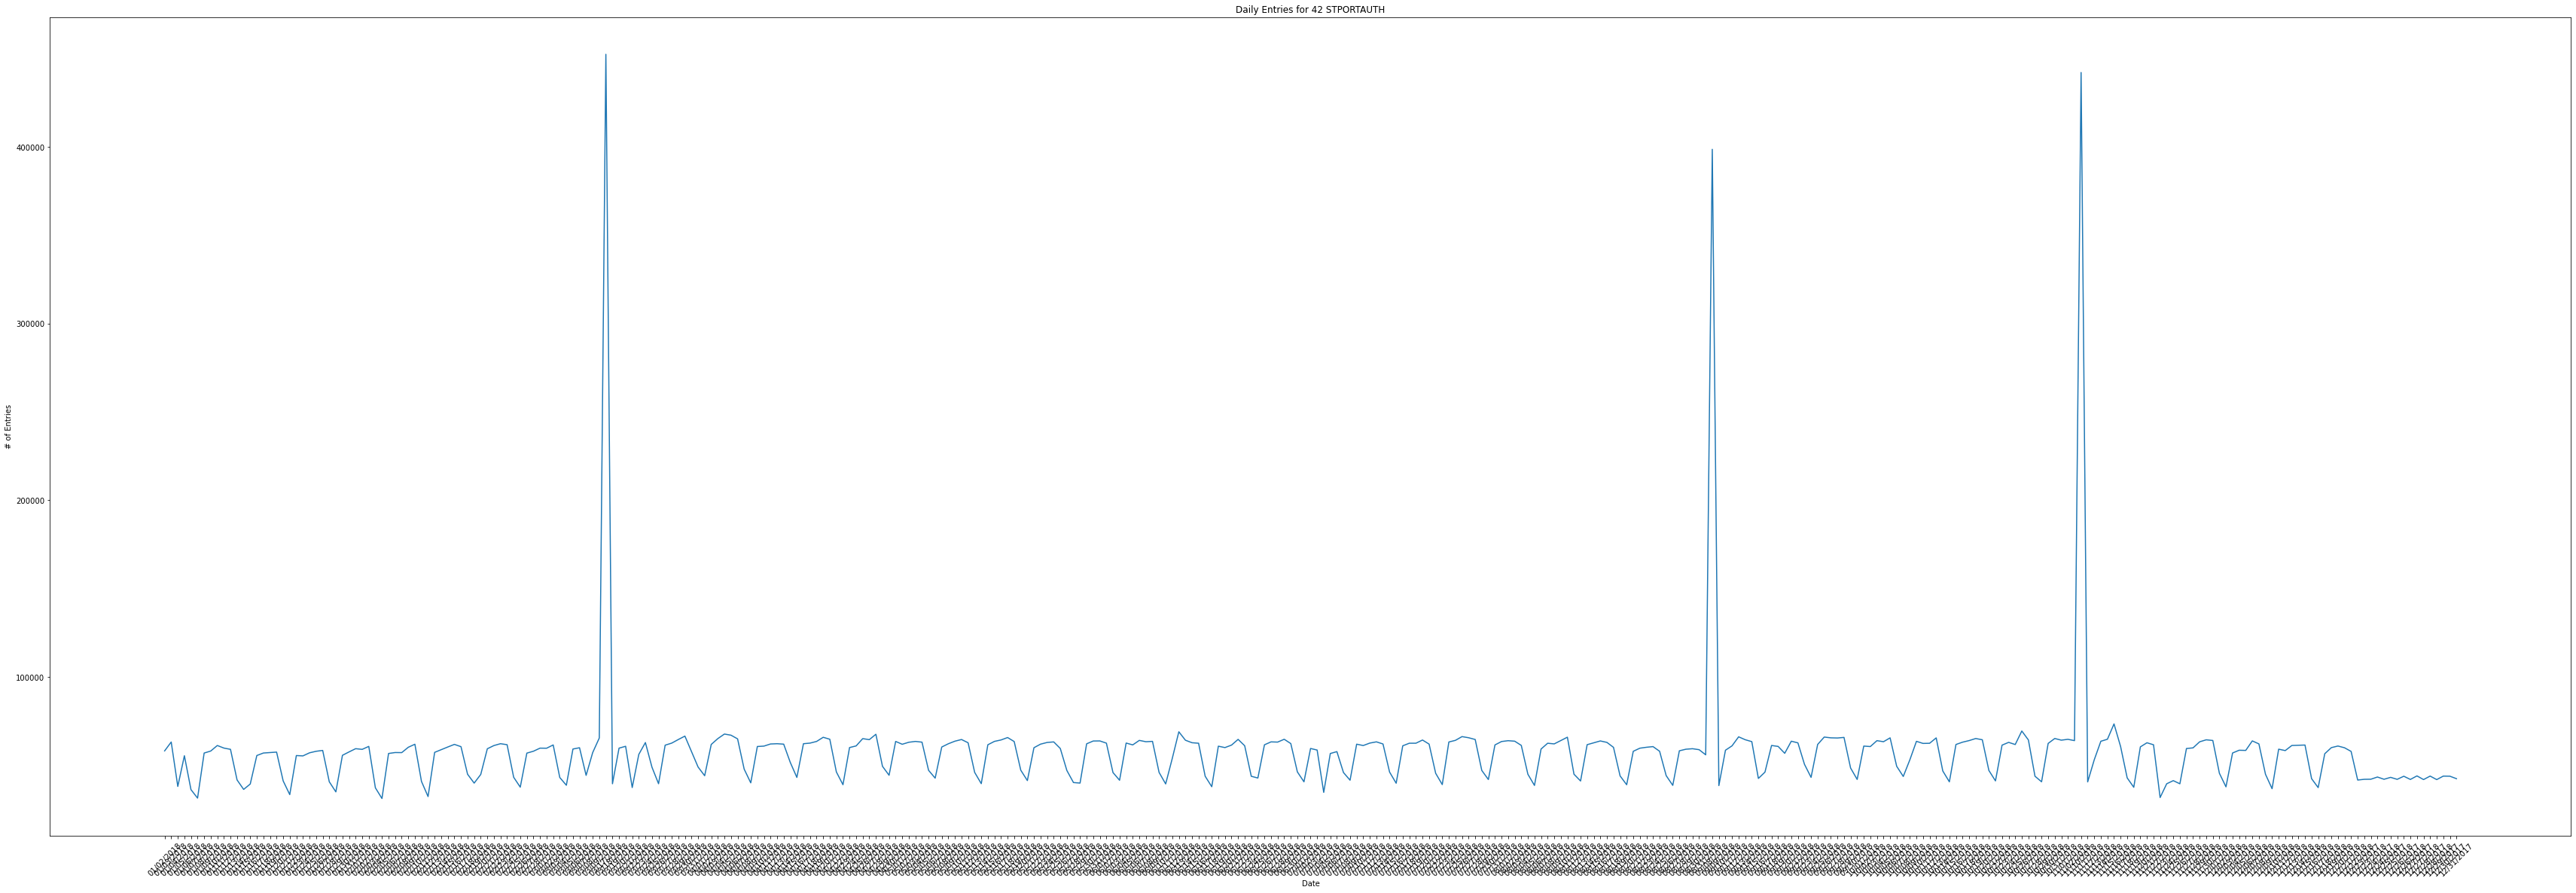

In [715]:
plt.figure(figsize=(60,20))
plt.plot(DAILY_STATION_42_STPORTAUTH['DATE'], DAILY_STATION_42_STPORTAUTH['DAILY_ENTRIES'])
plt.ylabel('# of Entries')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Daily Entries for 42 STPORTAUTH')
plt.savefig('graph42.png')


Text(0.5, 1.0, 'Daily Entries for STUPHIN ARCHER')

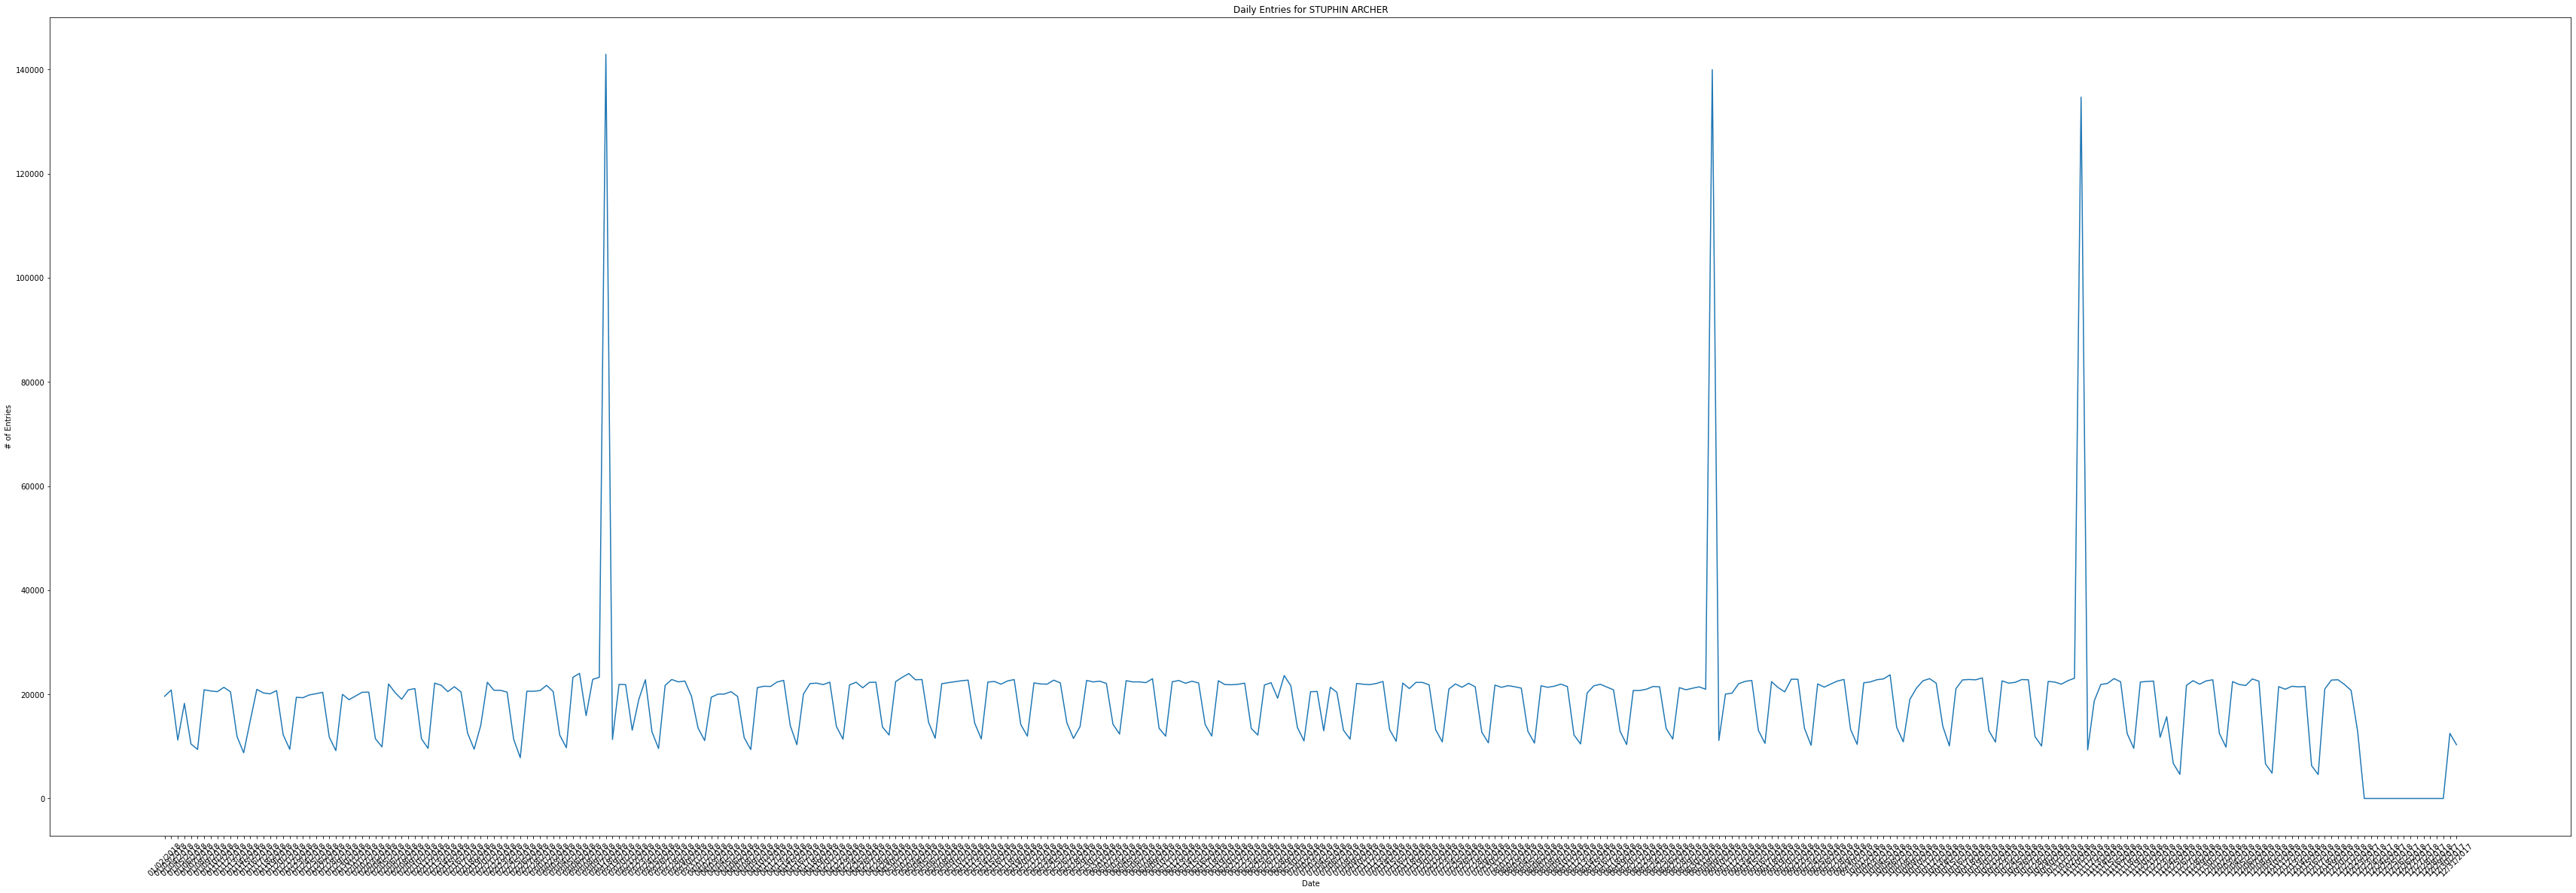

In [446]:
plt.figure(figsize=(60,20))
plt.plot(STUPHIN_ARCHER['DATE'], STUPHIN_ARCHER['DAILY_ENTRIES'])
plt.ylabel('# of Entries')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Daily Entries for STUPHIN ARCHER')

Text(0.5, 1.0, 'Daily Entries for JAY ST')

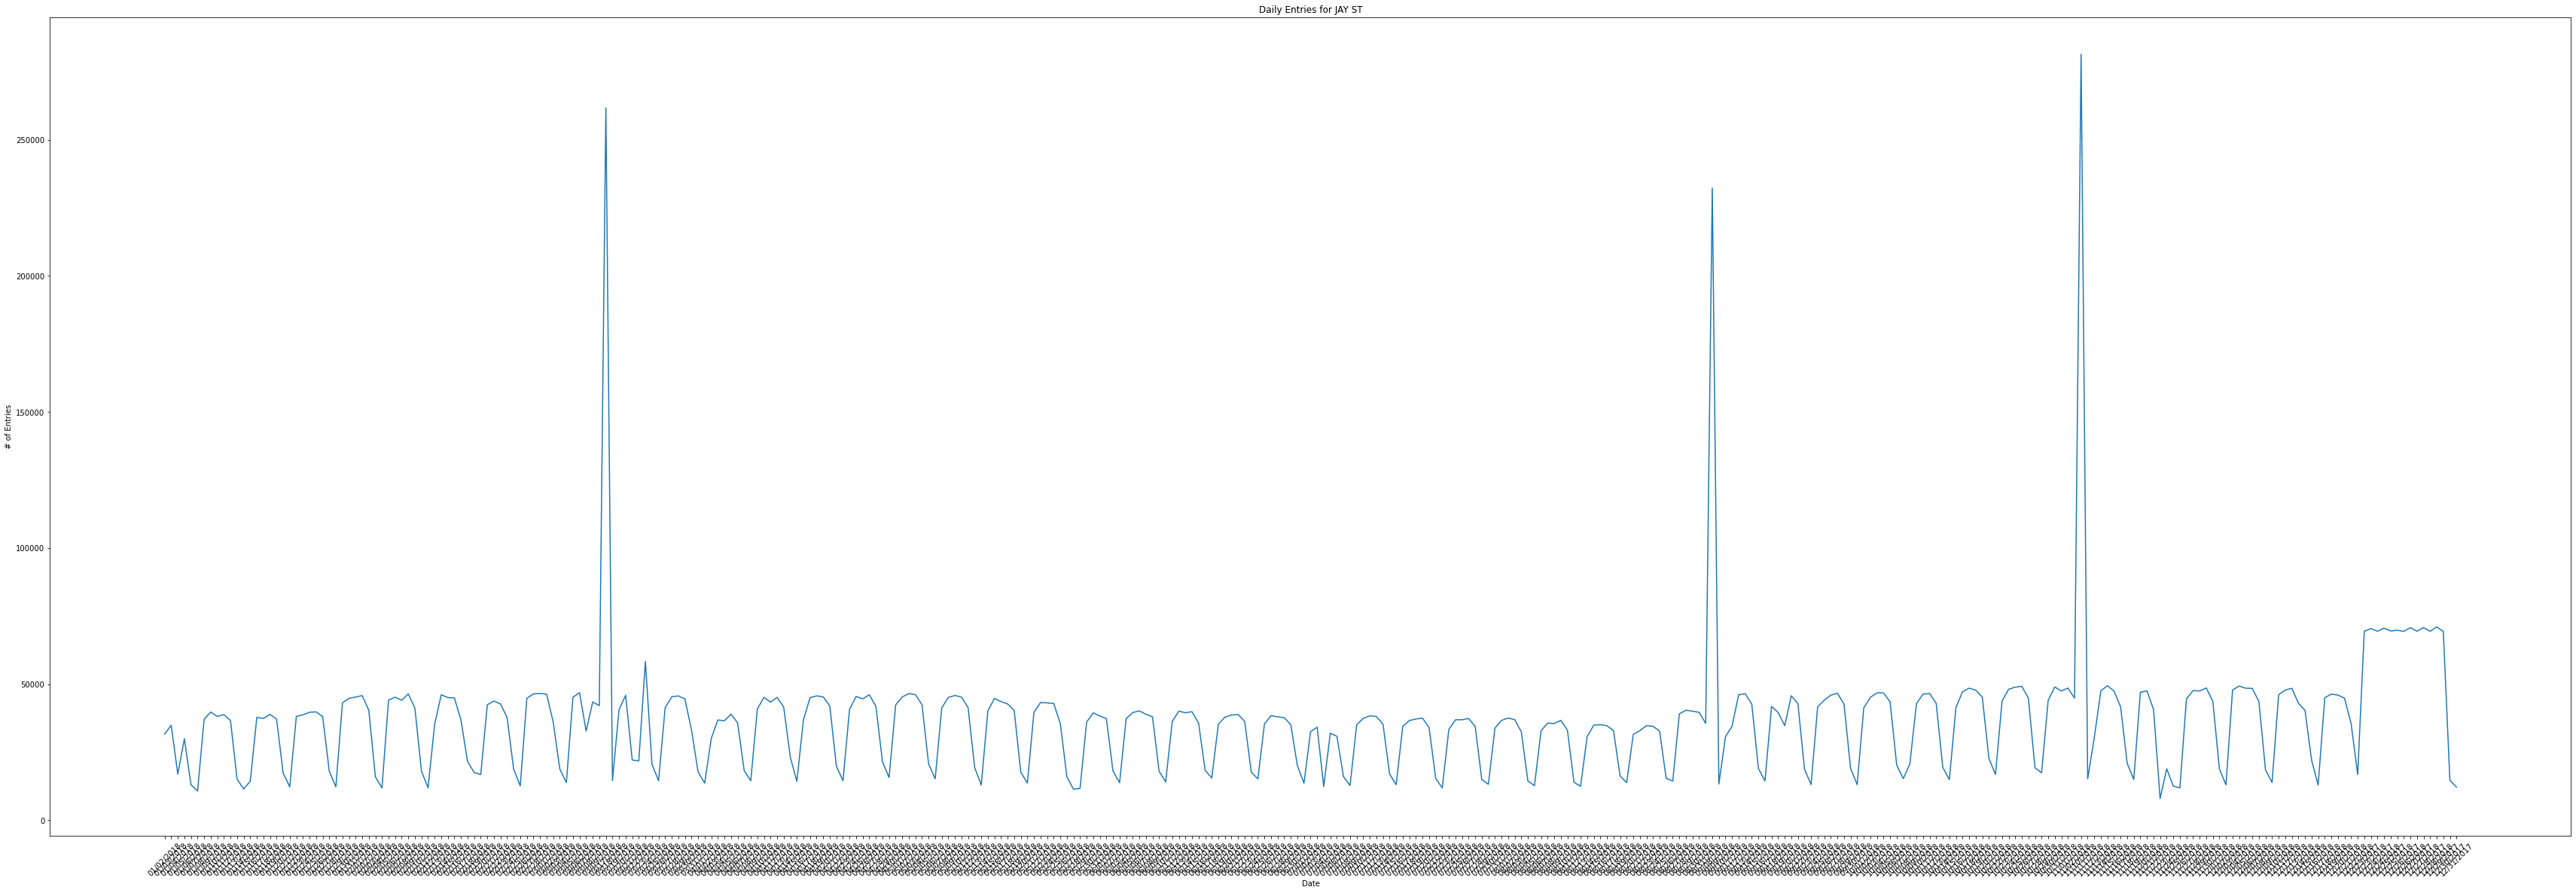

In [445]:
plt.figure(figsize=(60,20))
plt.plot(JAY_ST['DATE'], JAY_ST['DAILY_ENTRIES'])
plt.ylabel('# of Entries')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Daily Entries for JAY ST')

Text(0.5, 1.0, 'Daily Entries for 125 ST')

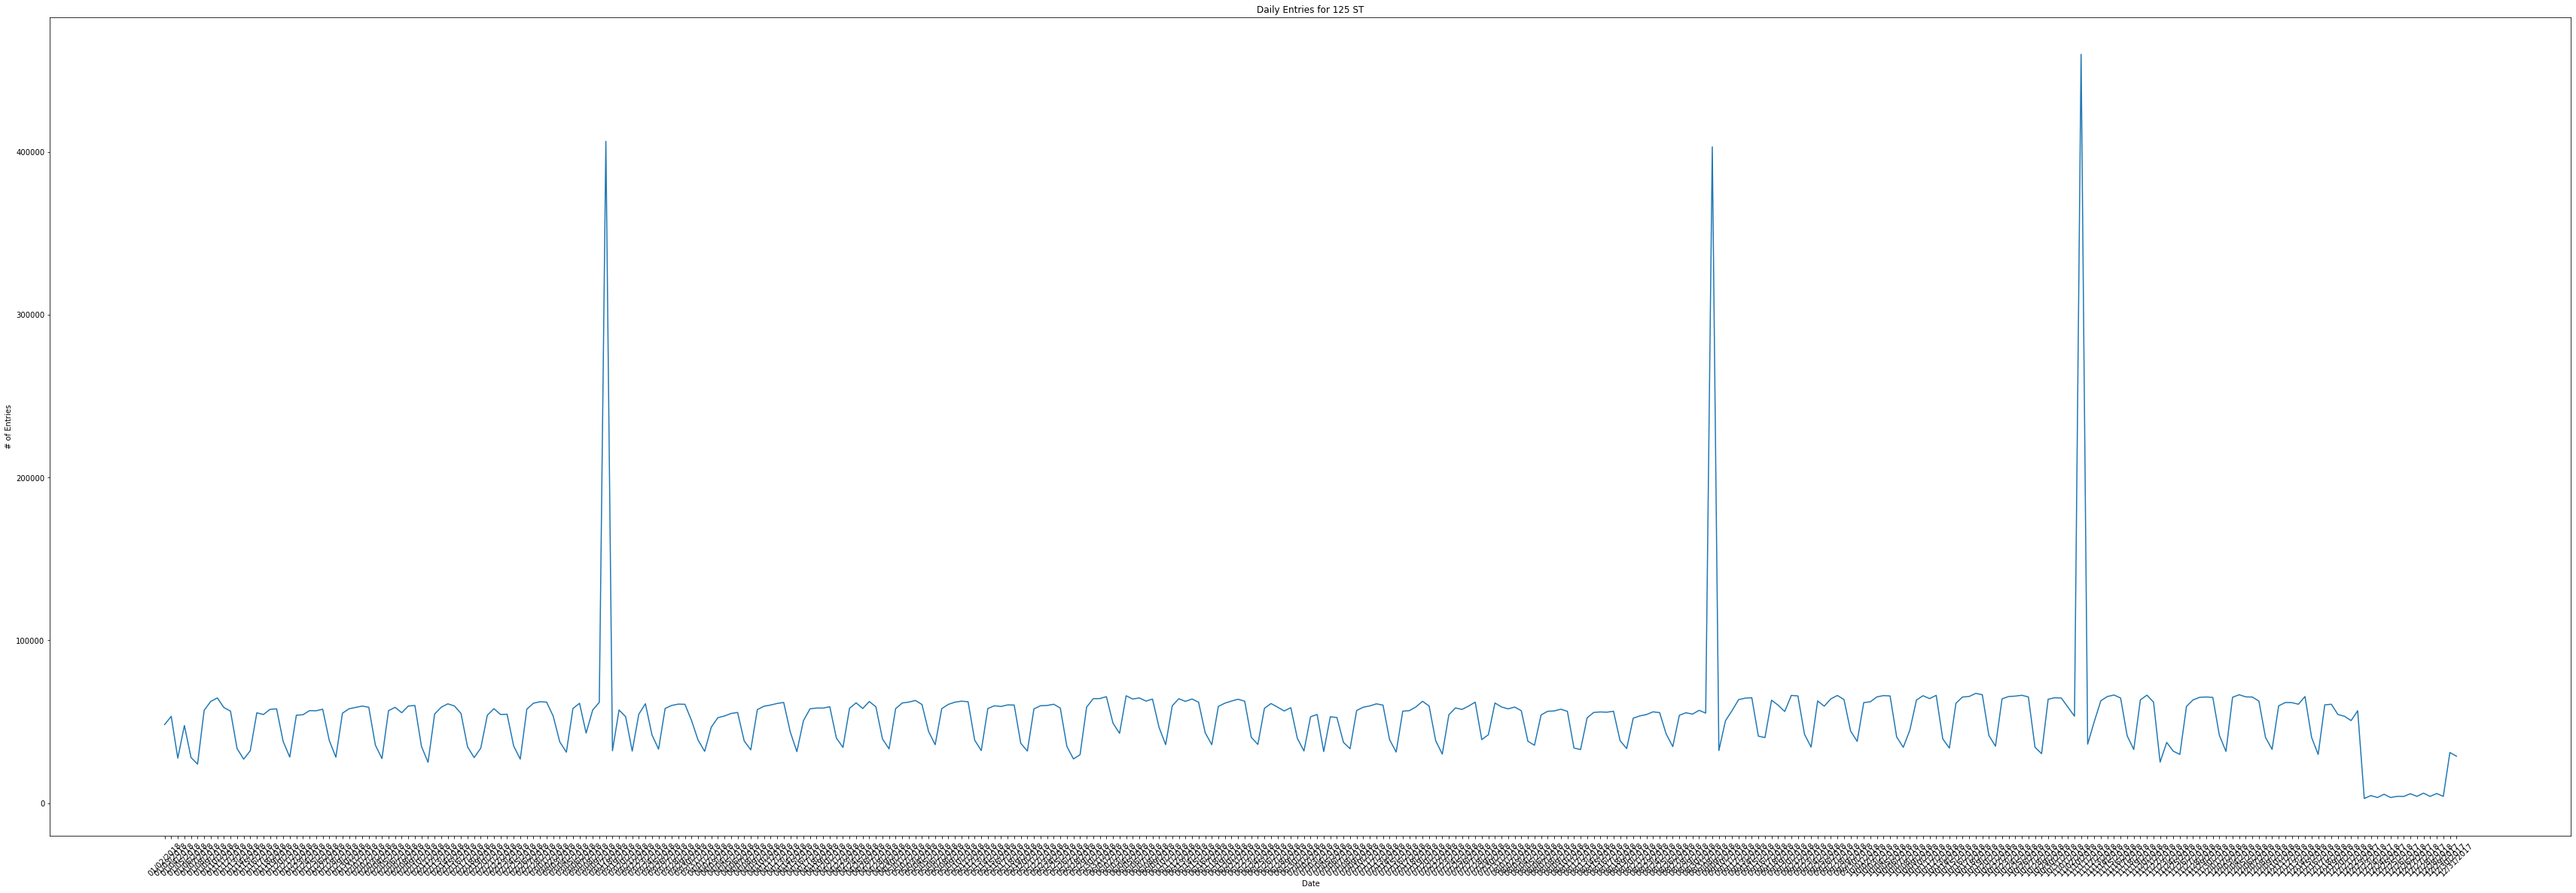

In [443]:
plt.figure(figsize=(60,20))
plt.plot(ST_125['DATE'], ST_125['DAILY_ENTRIES'])
plt.ylabel('# of Entries')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Daily Entries for 125 ST')

Text(0.5, 1.0, 'Daily Entries for DAILY_STATION_CONEY_ISLAND')

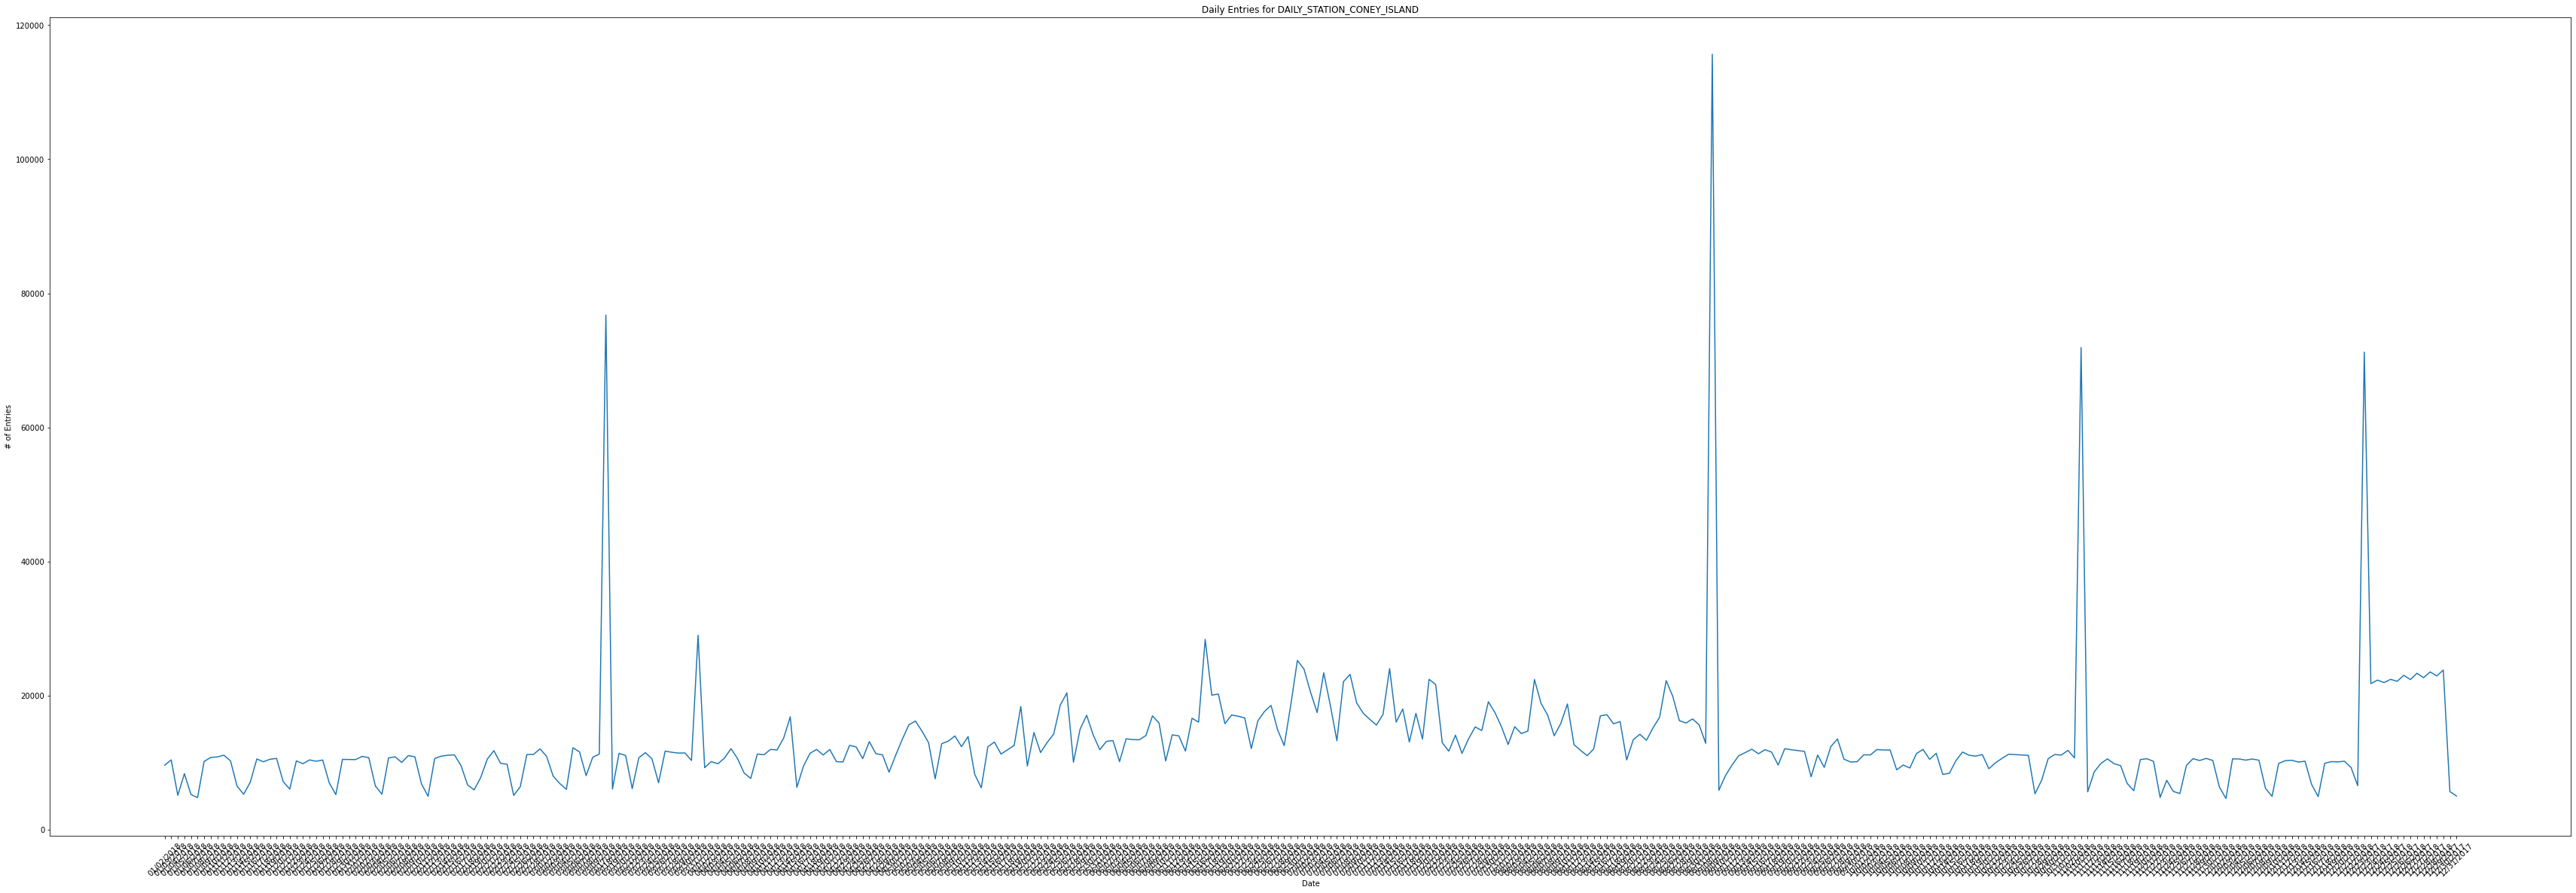

In [332]:
plt.figure(figsize=(60,20))
plt.plot(DAILY_STATION_CONEY_ISLAND['DATE'], DAILY_STATION_CONEY_ISLAND['DAILY_ENTRIES'])
plt.ylabel('# of Entries')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Daily Entries for DAILY_STATION_CONEY_ISLAND')

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(DAILY_STATION_42_STPORTAUTH['DATE'], DAILY_STATION_42_STPORTAUTH['DAILY_ENTRIES'])
plt.ylabel('# of Entries')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Daily Entries for DAILY_STATION_42_STPORTAUTH')

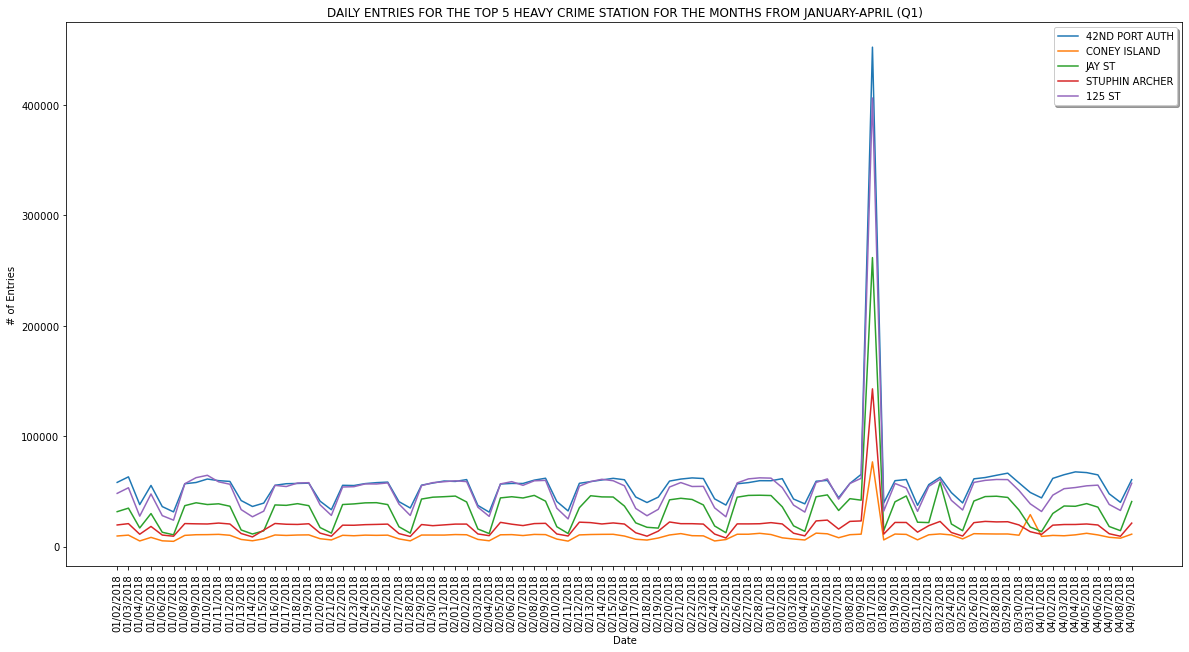

In [716]:
plt.figure(figsize=(20,10))
plt.plot(DAILY_STATION_42_STPORTAUTH_Q1['DATE'], DAILY_STATION_42_STPORTAUTH_Q1['DAILY_ENTRIES'])
plt.plot(DAILY_STATION_CONEY_ISLAND_Q1['DATE'], DAILY_STATION_CONEY_ISLAND_Q1['DAILY_ENTRIES'])
plt.plot(JAY_ST_Q1['DATE'], JAY_ST_Q1['DAILY_ENTRIES'])
plt.plot(STUPHIN_ARCHER_Q1['DATE'], STUPHIN_ARCHER_Q1['DAILY_ENTRIES'])
plt.plot(ST_125_Q1['DATE'], ST_125_Q1['DAILY_ENTRIES'])
plt.ylabel('# of Entries')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.title('DAILY ENTRIES FOR THE TOP 5 HEAVY CRIME STATION FOR THE MONTHS FROM JANUARY-APRIL (Q1)')
plt.legend(['42ND PORT AUTH','CONEY ISLAND','JAY ST','STUPHIN ARCHER','125 ST'],shadow = True, loc = 0);
plt.savefig('graphall.png')


In [470]:
#CALCULATING THE DAILY ENTRIES FOR EACH WEEK THROUGHT THE WHOLE TIME PERIOD (THE WHOLE PERIOD)
DAILY_STATION_42_STPORTAUTH['DAY_OF_WEEK_NUM'] = pd.to_datetime(DAILY_STATION_42_STPORTAUTH['DATE']).dt.dayofweek
DAILY_STATION_42_STPORTAUTH['WEEK_OF_YEAR'] = pd.to_datetime(DAILY_STATION_42_STPORTAUTH['DATE']).dt.week
DAILY_STATION_42_STPORTAUTH.head()

<ipython-input-470-620ce9b014c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DAILY_STATION_42_STPORTAUTH['DAY_OF_WEEK_NUM'] = pd.to_datetime(DAILY_STATION_42_STPORTAUTH['DATE']).dt.dayofweek
<ipython-input-470-620ce9b014c6>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  DAILY_STATION_42_STPORTAUTH['WEEK_OF_YEAR'] = pd.to_datetime(DAILY_STATION_42_STPORTAUTH['DATE']).dt.week
<ipython-input-470-620ce9b014c6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

,STATION,DATE,DAILY_ENTRIES,DAY_OF_WEEK_NUM,WEEK_OF_YEAR
22870,42 ST-PORT AUTH,01/02/2018,58183.0,1,1
22871,42 ST-PORT AUTH,01/03/2018,63204.0,2,1
22872,42 ST-PORT AUTH,01/04/2018,38062.0,3,1
22873,42 ST-PORT AUTH,01/05/2018,55448.0,4,1
22874,42 ST-PORT AUTH,01/06/2018,36261.0,5,1


In [471]:
#CALCULATING THE DAILY ENTRIES FOR EACH WEEK THROUGHT THE WHOLE TIME PERIOD (Q1)
DAILY_STATION_42_STPORTAUTH_Q1['DAY_OF_WEEK_NUM'] = pd.to_datetime(DAILY_STATION_42_STPORTAUTH_Q1['DATE']).dt.dayofweek
DAILY_STATION_42_STPORTAUTH_Q1['WEEK_OF_YEAR'] = pd.to_datetime(DAILY_STATION_42_STPORTAUTH_Q1['DATE']).dt.week

DAILY_STATION_CONEY_ISLAND_Q1['DAY_OF_WEEK_NUM'] = pd.to_datetime(DAILY_STATION_CONEY_ISLAND_Q1['DATE']).dt.dayofweek
DAILY_STATION_CONEY_ISLAND_Q1['WEEK_OF_YEAR'] = pd.to_datetime(DAILY_STATION_CONEY_ISLAND_Q1['DATE']).dt.week

JAY_ST_Q1['DAY_OF_WEEK_NUM'] = pd.to_datetime(JAY_ST_Q1['DATE']).dt.dayofweek
JAY_ST_Q1['WEEK_OF_YEAR'] = pd.to_datetime(JAY_ST_Q1['DATE']).dt.week

ST_125_Q1['DAY_OF_WEEK_NUM'] = pd.to_datetime(ST_125_Q1['DATE']).dt.dayofweek
ST_125_Q1['WEEK_OF_YEAR'] = pd.to_datetime(ST_125_Q1['DATE']).dt.week

STUPHIN_ARCHER_Q1['DAY_OF_WEEK_NUM'] = pd.to_datetime(STUPHIN_ARCHER_Q1['DATE']).dt.dayofweek
STUPHIN_ARCHER_Q1['WEEK_OF_YEAR'] = pd.to_datetime(STUPHIN_ARCHER_Q1['DATE']).dt.week


<ipython-input-471-659375782eff>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  DAILY_STATION_42_STPORTAUTH_Q1['WEEK_OF_YEAR'] = pd.to_datetime(DAILY_STATION_42_STPORTAUTH_Q1['DATE']).dt.week
<ipython-input-471-659375782eff>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  DAILY_STATION_CONEY_ISLAND_Q1['WEEK_OF_YEAR'] = pd.to_datetime(DAILY_STATION_CONEY_ISLAND_Q1['DATE']).dt.week
<ipython-input-471-659375782eff>:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  JAY_ST_Q1['WEEK_OF_YEAR'] = pd.to_datetime(JAY_ST_Q1['DATE']).dt.week
<ipython-input-471-659375782eff>:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  ST_125_Q1['WEEK_OF_YEAR'] = pd.to_datetime(ST_1

Text(0.5, 1.0, 'Ridership per day for Coney Island')

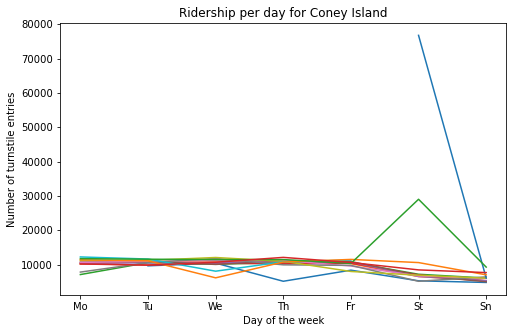

In [467]:
plt.figure(figsize=(8,5))

for i, group in DAILY_STATION_CONEY_ISLAND_Q1.groupby('WEEK_OF_YEAR'):
    plt.plot(group['DAY_OF_WEEK_NUM'], group['DAILY_ENTRIES'])
   
plt.xlabel('Day of the week')
plt.ylabel('Number of turnstile entries')
plt.xticks(np.arange(7),['Mo','Tu','We','Th','Fr','St','Sn'])
plt.title('Ridership per day for Coney Island For First Quarter')

Text(0.5, 1.0, 'Ridership per day for 24nd PortAuthority')

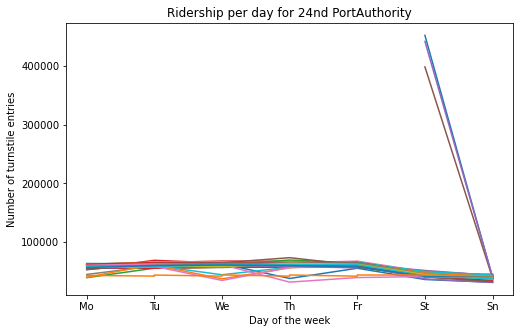

In [79]:
plt.figure(figsize=(8,5))

for i, group in DAILY_STATION_42_STPORTAUTH.groupby('WEEK_OF_YEAR'):
    plt.plot(group['DAY_OF_WEEK_NUM'], group['DAILY_ENTRIES'])
   
plt.xlabel('Day of the week')
plt.ylabel('Number of turnstile entries')
plt.xticks(np.arange(7),['Mo','Tu','We','Th','Fr','St','Sn'])
plt.title('Ridership per day for 24nd PortAuthority')

In [468]:
#CALCULATING THE DAILY ENTRIES FOR EACH WEEK THROUGHT THE WHOLE TIME PERIOD (YOU SPECIFIED THE MONTH OF JAN)
DAILY_STATION_42_STPORTAUTH_Q1['DAY_OF_WEEK_NUM'] = pd.to_datetime(DAILY_STATION_42_STPORTAUTH_Q1['DATE']).dt.dayofweek
DAILY_STATION_42_STPORTAUTH_Q1['WEEK_OF_YEAR'] = pd.to_datetime(DAILY_STATION_42_STPORTAUTH_Q1['DATE']).dt.week
DAILY_STATION_42_STPORTAUTH_Q1.head()

<ipython-input-468-81620b4decb9>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  DAILY_STATION_42_STPORTAUTH_Q1['WEEK_OF_YEAR'] = pd.to_datetime(DAILY_STATION_42_STPORTAUTH_Q1['DATE']).dt.week


,STATION,DATE,DAILY_ENTRIES,DAY_OF_WEEK_NUM,WEEK_OF_YEAR
22870,42 ST-PORT AUTH,01/02/2018,58183.0,1,1
22871,42 ST-PORT AUTH,01/03/2018,63204.0,2,1
22872,42 ST-PORT AUTH,01/04/2018,38062.0,3,1
22873,42 ST-PORT AUTH,01/05/2018,55448.0,4,1
22874,42 ST-PORT AUTH,01/06/2018,36261.0,5,1


Text(0.5, 1.0, 'Ridership per day for top 5 heavy crime stations for the first quarter of 2018')

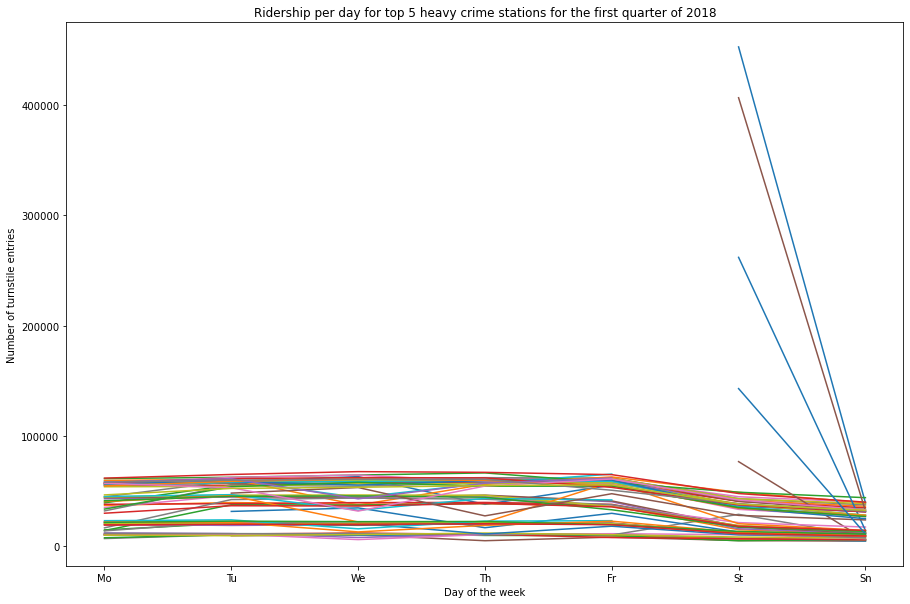

In [472]:
plt.figure(figsize=(15,10))

for i, group in DAILY_STATION_42_STPORTAUTH_Q1.groupby('WEEK_OF_YEAR'):
    plt.plot(group['DAY_OF_WEEK_NUM'], group['DAILY_ENTRIES'])
    
for i, group in DAILY_STATION_CONEY_ISLAND_Q1.groupby('WEEK_OF_YEAR'):
    plt.plot(group['DAY_OF_WEEK_NUM'], group['DAILY_ENTRIES'])
    
for i, group in JAY_ST_Q1.groupby('WEEK_OF_YEAR'):
    plt.plot(group['DAY_OF_WEEK_NUM'], group['DAILY_ENTRIES'])
    
for i, group in ST_125_Q1.groupby('WEEK_OF_YEAR'):
    plt.plot(group['DAY_OF_WEEK_NUM'], group['DAILY_ENTRIES'])
    
for i, group in STUPHIN_ARCHER_Q1.groupby('WEEK_OF_YEAR'):
    plt.plot(group['DAY_OF_WEEK_NUM'], group['DAILY_ENTRIES'])
   
plt.xlabel('Day of the week')
plt.ylabel('Number of turnstile entries')
plt.xticks(np.arange(7),['Mo','Tu','We','Th','Fr','St','Sn'])
plt.title('Ridership per day for top 5 heavy crime stations for the first quarter of 2018')

(array([276.,  67.,  15.,  11.,   2.,   3.,   3.,   1.,   0.,   1.]),
 array([2.80450000e+04, 4.84546710e+06, 9.66288920e+06, 1.44803113e+07,
        1.92977334e+07, 2.41151555e+07, 2.89325776e+07, 3.37499997e+07,
        3.85674218e+07, 4.33848439e+07, 4.82022660e+07]),
 <BarContainer object of 10 artists>)

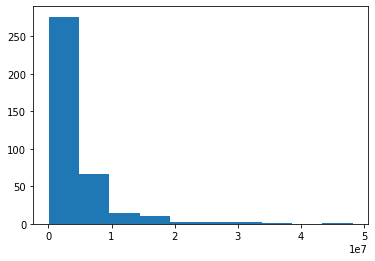

In [82]:
plt.hist(STATION_TOTALS['DAILY_ENTRIES'])

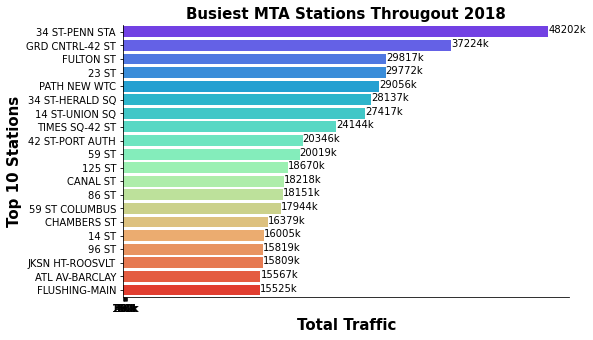

In [702]:
plt.figure(figsize=[8,5])
ax = sns.barplot(data=STATION_TOTALS.head(20).reset_index(),x='DAILY_ENTRIES',y='STATION',palette='rainbow')
plt.xlabel('Total Traffic',weight='bold',fontsize=15)
plt.ylabel('Top 10 Stations',weight='bold',fontsize=15)
plt.xticks(range(0,400001,50000),[str(int(i/1000))+'k' for i in range(0,400001,50000)])
plt.title('Busiest MTA Stations Througout 2018', weight='bold',fontsize='15')
for p in ax.patches:
        ax.annotate(str(int(p.get_width()/1000))+'k', (p.get_width(), p.get_y()+0.5))
sns.despine()
plt.savefig('graph11.png')

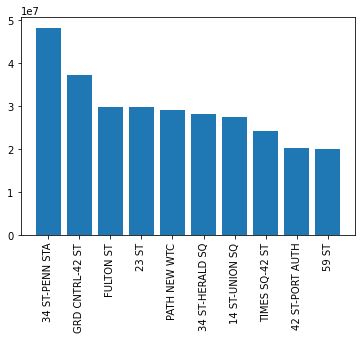

In [701]:
plt.bar(x=STATION_TOTALS['STATION'][:10], height=STATION_TOTALS['DAILY_ENTRIES'][:10])
plt.xticks(rotation=90)
plt.savefig('graph10.png')

In [482]:
# DROPPING THE UNNECCESARY COLUMNS LIKE JURISDICTION CODE , ARREST PERCINT , LINE , ARREST KEY AND GEOMETRY
ARRESTASSIGNED = ARRESTASSIGNED.drop(["ARREST_KEY",'objectid','EXITS','ENTRIES','Longitude','Latitude', "JURISDICTION_CODE",'ARREST_PRECINCT','geometry', 'line','index'], axis=1, errors="ignore")

In [483]:
#SPICIFYING THE CIMES HAPPENING IN 2018
ARRESTASSIGNED = ARRESTASSIGNED[ARRESTASSIGNED['ARREST_DATE'] >= '2018-01-01']
ARRESTASSIGNED.rename(columns={'name':'STATION'}, inplace=True)
ARRESTASSIGNED

,ARREST_DATE,ARREST__BORO,AGE_GROUP,PERP_SEX,PERP_RACE,STATION,notes
262345,2018-12-28,M,25-44,M,WHITE HISPANIC,Union Sq - 14th St,L-all times
262346,2018-12-28,K,25-44,M,WHITE,86th St,R-all times
262347,2018-12-28,B,45-64,M,BLACK,Brook Ave,6-all times
262348,2018-12-28,Q,45-64,F,BLACK,Sutphin Blvd - Archer Av,"E,J-all times, Z-rush hours AM westbound, PM e..."
262349,2018-12-28,Q,25-44,M,UNKNOWN,Sutphin Blvd - Archer Av,"E,J-all times, Z-rush hours AM westbound, PM e..."
...,...,...,...,...,...,...,...
268315,2018-01-02,M,25-44,M,BLACK,49th St,"N-all times, Q-all times exc weekends, R-all t..."
268316,2018-01-02,M,45-64,M,BLACK HISPANIC,8th Ave,L-all times
268317,2018-01-02,B,18-24,M,BLACK HISPANIC,Kingsbridge Rd,"B-rush hours, D-all times"
268318,2018-01-01,M,18-24,M,WHITE HISPANIC,42nd St - Port Authority Bus Term,"A,E-all times, C-all times exc nights"


In [484]:
def renaming_stations(name):
    
    if name=='42nd St - Port Authority Bus Term':
        return '42 ST-PORT AUTH'
    
    elif name=='Coney Island - Stillwell Av': 
        return 'CONEY IS-STILLW'
    
    elif name=='125th St': 
        return '125 ST'
    
    elif name=='Sutphin Blvd - Archer Av': 
        return 'SUTPHIN-ARCHER'
    
    elif name=='Jay St - MetroTech': 
        return 'JAY ST-METROTEC'
    
    elif name=='Times Sq - 42nd St': 
        return 'TIMES SQ-42 ST'
    
    elif name=='3rd Ave - 149th St': 
        return '3 AV-149 ST'
    
    elif name=='Jamaica Ctr - Parsons / Archer': 
        return 'JAMAICA CENTER'
    
    elif name=='Nostrand Ave': 
        return 'NOSTRAND AV'
    
    elif name=='Sutter Ave': 
        return 'SUTTER AV-RUTLD'
    
    elif name=='3rd Ave - 138th St': 
        return '3 AV 138 ST'
    
    elif name=='116th St': 
        return '116 ST'
    
    elif name=='Utica Ave': 
        return 'UTICA AV'
    
    elif name=='34th St - Penn Station': 
        return '34 ST-PENN STA'
    
    elif name=='Crown Hts - Utica Ave': 
        return 'CROWN HTS-UTICA'
    
    elif name=='Fordham Rd': 
        return 'FORDHAM RD'
    
    elif name=='86th St': 
        return '86 ST'
    
    elif name=='59th St': 
        return '59 ST'
    
    elif name=='33rd St': 
        return '33 ST'
    
    elif name=='Nevins St': 
        return 'NEVINS ST'
    
    elif name=='Kingsbridge Rd': 
        return 'KINGSBRIDGE RD'
    
    elif name=='Prospect Ave': 
        return 'PROSPECT AV'
    
    elif name=='Hoyt - Schermerhorn Sts': 
        return 'HOYT-SCHER'
    
    elif name=='Tremont Ave': 
        return 'TREMONT AV'
    
    elif name=='Lexington Ave - 59th St': 
        return 'LEXINGTON AV/53'
    
    elif name=='23rd St': 
        return '23 ST'
    
    elif name=='50th St': 
        return '50 ST'
    
    elif name=='96th S': 
        return '96 ST'
    
    elif name=='E 180th St': 
        return 'E 180 ST'
    
    elif name=='174th St': 
        return '174 ST'
    
    elif name=='Borough Hall': 
        return 'BOROUGH HALL'
    
    elif name=='Herald Sq - 34th St': 
        return '34 ST-HERALD SQ'
    
    elif name=='170th St': 
        return '170 ST'
    
    elif name=="Atlantic Av - Barclay's Center": 
        return 'ATLANTIC AV'
    
    elif name=="28th St": 
        return '28 ST'
    
    elif name=="Simpson St": 
        return 'SIMPSON ST'
    
    elif name=="59th St - Columbus Circle": 
        return '59 ST COLUMBUS'
    
    elif name=="Myrtle - Wyckoff Aves": 
        return 'MYRTLE-WYCKOFF'
    
    elif name=="Mt Eden Ave": 
        return 'MT EDEN AV'
    
    elif name=="Freeman St": 
        return 'FREEMAN ST'
    
    elif name=="Rockaway Ave": 
        return 'ROCKAWAY AV'
    
    elif name=="Canarsie - Rockaway Pkwy": 
        return 'CANARSIE-ROCKAW'
    
    elif name=="Hunts Point Ave": 
        return 'HUNTS POINT AV'
    
    elif name=="Euclid Ave": 
        return 'EUCLID AV'
    
    elif name=="Kings Hwy": 
        return 'KINGS HWY'
    
    elif name=="Van Siclen Ave": 
        return 'VAN SICLEN AVE'
    
    elif name=="DeKalb Ave": 
        return 'DEKALB AV'
    
    elif name=="183rd St": 
        return '183 ST'
    
    elif name=="49th St": 
        return '49 ST'
    
    elif name=="145th St": 
        return '145 ST'
    
    elif name=="Burnside Ave": 
        return 'BURNSIDE AV'
    
    elif name=="Far Rockaway - Mott Ave": 
        return 'FAR ROCKAWAY'
    
    elif name=="Grand Central - 42nd St": 
        return 'GRD CNTRL-42 ST'
    
    elif name=="South Ferry": 
        return 'SOUTH FERRY'
    
    elif name=="169th St": 
        return '169 ST'
    
    elif name=="Wakefield - 241st St": 
        return 'WAKEFIELD/241'
    
    elif name=="Bleecker St": 
        return 'BLEECKER ST'
    
    elif name=="53rd St": 
        return '53 ST'
    
    elif name=="135th St": 
        return '135 ST'
    
    elif name=="176th St": 
        return '176 ST'
    
    elif name=="110th St": 
        return '110 ST'
    
    elif name=="Morrison Av - Soundview": 
        return 'MORISN AV/SNDVW'
    
    elif name=="Sutter Ave - Rutland Road": 
        return 'SUTTER AV-RUTLD'
    
    elif name=="Franklin Ave - Fulton St": 
        return 'FRANKLIN AV'
    
    elif name=="Halsey St": 
        return 'HALSEY ST'
    
    elif name=="Sheepshead Bay": 
        return 'SHEEPSHEAD BAY'
    
    elif name=="219th St": 
        return '219 ST'
    
    elif name=="W 4th St - Washington Sq (Upper)": 
        return 'W 4 ST-WASH SQ'
    
    elif name=="Bergen St": 
        return 'BERGEN ST'
    
    elif name=="Beach 60th St": 
        return 'BEACH 60 ST'
    
    elif name=="West Farms Sq - E Tremont Av": 
        return 'WEST FARMS SQ'
    
    elif name=="Morgan Ave": 
        return 'MORGAN AV'
    
    elif name=="Grand Ave - Newtown": 
        return 'GRAND-NEWTOWN'
    
    elif name=="42nd St - Bryant Pk": 
        return '42 ST-BRYANT PK'
    
    elif name=="Church Ave": 
        return 'CHURCH AV'
    
    elif name=="Jackson Hts - Roosevelt Av": 
        return 'JKSN HT-ROOSVLT'
    
    elif name=="168th St": 
        return '168 ST'
    
    elif name=="Beach 67th St": 
        return 'BEACH 67 ST'
    
    elif name=="Flushing - Main St": 
        return 'FLUSHING-MAIN'
    
    elif name=="Bay 50th St": 
        return 'BAY 50 ST'
    
    elif name=="103rd St": 
        return '103 ST'
    
    elif name=="174th-175th Sts": 
        return '174-175 STS'
    
    elif name=="182nd-183rd Sts": 
        return '182-183 STS'
    
    elif name=="Livonia Ave": 
        return 'LIVONIA AV'
    
    elif name=="Kosciuszko St": 
        return 'KOSCIUSZKO ST'
    
    elif name=="8th Ave": 
        return '8 AV'
    
    elif name=="Allerton Ave": 
        return 'ALLERTON AV'
    
    elif name=="Saratoga Ave":
        return 'SARATOGA AV '
    
    elif name=="Fulton St": 
        return 'FULTON ST'
    
    elif name=="45th St": 
        return '45 ST'
    
    elif name=="Franklin Ave": 
        return 'FRANKLIN AV'
    
    elif name=="Bedford - Nostrand Aves": 
        return 'BEDFORD-NOSTRAN'
    
    elif name=="Brook Ave": 
        return 'BROOK AV'
    
    elif name=="Prospect Park": 
        return 'PROSPECT PAR' 
    
    elif name=="36th St": 
        return '36 ST' 
    
    elif name=="Newkirk Ave": 
        return 'NEWKIRK AV' 
    
    elif name=="Ralph Ave": 
        return 'RALPH AV' 
    
    elif name=="Broadway Junction": 
        return 'BROADWAY JCT' 
    
    elif name=="Central Park North (110th St)": 
        return 'CENTRAL PK N110' 
    
    elif name=="Cypress Ave": 
        return 'CYPRESS AV' 
    
    elif name=="Flushing Ave": 
        return 'FLUSHING AV' 
    
    elif name=="Ave J": 
        return 'AVENUE J' 
    
    elif name=="Marcy Ave": 
        return 'MARCY AV' 
    
    elif name=="E 149th St": 
        return 'E 149 ST' 
    
    elif name=="Norwood - 205th St": 
        return 'NORWOOD 205 ST' 
    
    elif name=="Lower East Side - 2nd Ave": 
        return '2 AV' 
    
    elif name=="149th St - Grand Concourse": 
        return '149/GRAND CONC' 
    
    elif name=="Beach 25th St": 
        return 'BEACH 25 ST' 
    
    elif name=="Winthrop St": 
        return 'WINTHROP ST' 
    
    elif name=="Kingston - Throop Aves": 
        return 'KINGSTON-THROOP' 
    
    elif name=="Gates Ave": 
        return 'GATES AV' 
    
    elif name=="Ozone Park - Lefferts Blvd": 
        return 'OZONE PK LEFFRT' 
    
    elif name=="Bay Pky": 
        return 'BAY PKWY' 
    
    elif name=="Bedford Ave": 
        return 'BEDFORD AV' 
    
    elif name=="Union Sq - 14th St": 
        return 'UNION ST' 
    
    elif name=="Elder Ave": 
        return 'ELDER AV' 
    
    elif name=="Woodhaven Blvd - Queens Mall": 
        return 'WOODHAVEN BLVD'
    
    elif name=="Whitehall St": 
        return 'WHITEHALL S-FRY' 
    
    elif name=="Gun Hill Rd": 
        return 'GUN HILL RD'
    
    elif name=="Montrose Ave": 
        return 'MONTROSE AV'
    
    elif name=="Brighton Beach": 
        return 'BRIGHTON BEACH'
    
    elif name=="14th St": 
        return '14TH STREET'
    
    elif name=="Beach 44th St": 
        return 'BEACH 44 ST'
    
    elif name=="72nd St": 
        return '72 ST'
    
    elif name=="W 8th St - NY Aquarium": 
        return 'W 8 ST-AQUARIUM'
    
    elif name=="Cathedral Pkwy (110th St)": 
        return 'CATHEDRAL PKWY'
    
    elif name=="Myrtle-Willoughby Aves": 
        return 'MYRTLE-WILLOUGH'
    
    elif name=="Jamaica - 179th St": 
        return 'JAMAICA 179 ST'
    
    elif name=="Brooklyn College - Flatbush Ave": 
        return 'FLATBUSH AV-B.C'
    
    elif name=="Myrtle Ave": 
        return 'MYRTLE AV'
    
    elif name=="East Broadway": 
        return 'EAST BROADWAY'
    
    elif name=="Dyckman St": 
        return 'DYCKMAN ST'
    
    elif name=="Smith - 9th Sts": 
        return 'SMITH-9 ST'
    
    elif name=="Woodlawn": 
        return 'WOODLAWN'
    
    elif name=="New Lots Ave": 
        return 'NEW LOTS AV'
    
    elif name=="Grant Ave": 
        return 'GRANT AV'
    
    elif name=="157th St": 
        return '157 ST'
    
    elif name=="57th St": 
        return '57 ST'
    
    elif name=="6th Ave": 
        return '6 AV'
    
    elif name=="82nd St - Jackson Hts": 
        return '82 ST-JACKSON H'
    
    elif name=="Castle Hill Ave": 
        return 'CASTLE HILL AV'
    
    elif name=="Ave M": 
        return 'AVENUE M'
    
    elif name=="Franklin St": 
        return 'FRANKLIN ST'
    
    elif name=="207th St": 
        return '207 ST'
    
    elif name=="Canal St": 
        return 'CANAL ST'
    
    elif name=="Kew Gardens - Union Tpke": 
        return 'KEW GARDENS'
    
    elif name=="181st St": 
        return '181 ST'
    
    elif name=="74th St - Broadway": 
        return '74 ST-BROADWAY'
    
    elif name=="Clinton - Washington Aves": 
        return 'CLINTON-WASH AV'
    
    elif name=="79th St": 
        return '79 ST'
    
    elif name=="25th Ave": 
        return '25 AV'
    
    elif name=="St Lawrence Ave": 
        return 'ST LAWRENCE AV'
    
    elif name=="Delancey St - Essex St": 
        return 'DELANCEY/ESSEX'
    
    elif name=="90th St - Elmhurst Av": 
        return '90 ST-ELMHURST'
    
    elif name=="Grand St": 
        return 'GRAND ST'
    
    elif name=="138th St - Grand Concourse": 
        return '138/GRAND CONC'
    
    elif name=="Rockaway Blvd": 
        return 'ROCKAWAY BLVD'
    
    elif name=="Atlantic Ave": 
        return 'ATLANTIC AV'
    
    elif name=="4th Av - 9th St": 
        return '4 AV-9 ST'
    
    elif name=="Queens Plz": 
        return 'QUEENS PLAZA'
    
    elif name=="Lorimer St": 
        return 'LORIMER ST'
    
    elif name=="Ft Hamilton Pkwy": 
        return 'FT HAMILTON PKY'
    
    elif name=="Mosholu Pkwy": 
        return 'MOSHOLU PKWY'
    
    elif name=="Ave U": 
        return 'AVENUE U'
    
    elif name=="66th St - Lincoln Ctr": 
        return '66 ST-LINCOLN'
    
    elif name=="18th Ave": 
        return '18 AV'
    
    elif name=="Burke Ave": 
        return 'BURKE AV'
    
    elif name=="Whitlock Ave": 
        return 'WHITLOCK AV'
    
    elif name=="Brooklyn Bridge - City Hall": 
        return 'BROOKLYN BRIDGE'
    
    elif name=="Junius St": 
        return 'JUNIUS ST'
    
    elif name=="77th St": 
        return '77 ST'
    
    elif name=="51st St": 
        return '51 ST'
    
    elif name=="Chambers St": 
        return 'CHAMBERS ST'
    
    elif name=="Bronx Park East": 
        return 'BRONX PARK EAST'
    
    elif name=="7th Ave": 
        return '7 AV'
    
    elif name=="Forest Hills - 71st A": 
        return 'FOREST HILLS 71'
    
    elif name=="Ocean Pkwy": 
        return 'OCEAN PKWY'
    
    elif name=="Briarwood - Van Wyck Blvd": 
        return 'BRIARWOOD'
    
    elif name=="80th St": 
        return '80 ST'
    
    elif name=="47th-50th Sts - Rockefeller Ctr": 
        return '47-50 STS ROCK'
    
    elif name=="Jackson Ave": 
        return 'ASTORIA BLV'
    
    elif name=="Graham Ave": 
        return 'GRAHAM AV'
    
    elif name=="Woodside - 61st St": 
        return '61 ST WOODSIDE'
    
    elif name=="25th St": 
        return '25 ST'
    
    elif name=="Intervale Ave": 
        return 'INTERVALE AV'
    
    elif name=="Pennsylvania Ave": 
        return 'PENNSYLVANIA AV'
    
    elif name=="Prince St": 
        return 'PRINCE ST'
    
    elif name=="Crescent St": 
        return 'CRESCENT ST'
    
    elif name=="Beach 90th St": 
        return 'BEACH 90 ST'
    
    elif name=="137th St - City College": 
        return '137 ST CITY COL'
    
    elif name=="Parkside Ave": 
        return 'PARKSIDE AV'
    
    elif name=="Alabama Ave": 
        return 'ALABAMA AV'
    
    elif name=="Hoyt St": 
        return 'HOYT ST'
    
    elif name=="Beverly Rd": 
        return 'BEVERLY RD'
    
    elif name=="Parsons Blvd": 
        return 'PARSONS BLVD'
    
    elif name=="68th St - Hunter College": 
        return '68ST-HUNTER CO'
    
    elif name=="Jefferson St": 
        return 'JEFFERSON ST'
    
    elif name=="Eastchester - Dyre Ave": 
        return 'EASTCHSTER/DYRE'
    
    elif name=="Woodhaven Blvd": 
        return 'WOODHAVEN BLVD'
    
    elif name=="103rd St - Corona Plaza": 
        return '103 ST-CORONA'
    
    elif name=="63rd Dr - Rego Park": 
        return '63 DR-REGO PARK'
    
    elif name=="Longwood Ave": 
        return 'LONGWOOD AV'
    
    elif name=="Inwood - 207th St": 
        return 'INWOOD-207 ST'
    
    elif name=="Broadway": 
        return 'BROADWAY'
    
    elif name=="ereid Ave (238 St)": 
        return 'NEREID AV'
    
    elif name=="20th Ave": 
        return '20 AV'
    
    elif name=="Broad St": 
        return 'BROAD ST'
    
    elif name=="Wilson Ave": 
        return 'WILSON AV'
    
    elif name=="York St": 
        return 'YORK ST'
    
    elif name=="Broadway - Lafayette St": 
        return 'LAFAYETTE AV'
    
    elif name=="E 143rd St - St Mary's St": 
        return "E 143/ST MARY'S"
    
    elif name=="Kingston Ave": 
        return "KINGSTON AV"
    
    elif name=="Bowling Green": 
        return "BOWLING GREEN"
    
    elif name=="104th St": 
        return "104 ST"
    
    elif name=="Spring St": 
        return "SPRING ST"
    
    elif name=="Canal St - Holland Tunnel": 
        return "CANAL ST"
    
    elif name=="Junction Blvd": 
        return "JUNCTION BLVD"
    
    elif name=="Eastern Pkwy - Bklyn Museum": 
        return "EASTN PKWY-MUSM"
    
    elif name=="Westchester Sq - E Tremont Ave": 
        return "WESTCHESTER SQ"
    
    elif name=="Steinway St": 
        return "STEINWAY ST"
    
    elif name=="Queensboro Plz": 
        return "QUEENSBORO PLZ"
    
    elif name=="Long Island City - Court Sq": 
        return "COURT SQ"
    
    elif name=="Ave H": 
        return "AVENUE H"
    
    elif name=="18th St": 
        return "18 ST"
    
    elif name=="Bowery": 
        return "BOWERY"
    
    elif name=="Parkchester": 
        return "PARKCHESTER"
    
    elif name=="Cortlandt St": 
        return "CORTLANDT ST"
    
    elif name=="Sutphin Blvd": 
        return "SUTPHIN BLVD"
    
    elif name=="Bay Ridge Ave": 
        return "BAY RIDGE AV"
    
    elif name=="Sterling St": 
        return "STERLING ST"
    
    elif name=="175th St": 
        return "175 ST"
    
    elif name=="Vernon Blvd - Jackson Ave": 
        return "VERNON-JACKSON"
    
    elif name=="High St": 
        return "HIGH ST"
    
    elif name=="88th St": 
        return "88 ST"
    
    elif name=="E 105th St": 
        return "EAST 105 ST"
    
    elif name=="Park Pl": 
        return "PARK PLACE"
    
    elif name=="Astor Pl": 
        return "ASTOR PL"
    
    elif name=="Nassau Ave": 
        return "NASSAU AV"
    
    elif name=="Gravesend - 86th St": 
        return "86 ST"
    
    elif name=="Houston St": 
        return "HOUSTON ST"
    
    elif name=="52nd St": 
        return "52 ST"
    
    elif name=="W 4th St - Washington Sq (Lower)": 
        return "W 4 ST-WASH SQ"
    
    elif name=="Botanic Garden": 
        return "BOTANIC GARDEN"
    
    elif name=="Rector St": 
        return "RECTOR ST"
    
    elif name=="36th Ave": 
        return "36 AV"
    
    elif name=="191st St": 
        return "191 ST"
    
    elif name=="155th St": 
        return "155 ST"
    
    elif name=="Astoria - Ditmars Blvd": 
        return "ASTORIA DITMARS"
    
    elif name=="Morris Park": 
        return "MORRIS PARK"
    
    elif name=="Knickerbocker Ave": 
        return "KNICKERBOCKER"
    
    elif name=="111th St": 
        return "111 ST"
    
    elif name=="Shepherd Ave": 
        return "SHEPHERD AV"
    
    elif name=="21st St - Queensbridge": 
        return "21 ST-QNSBRIDGE"
    
    elif name=="Norwood Ave": 
        return "NORWOOD 205 ST"
    
    elif name=="5th Ave - Bryant Pk": 
        return "5 AVE"
    
    elif name=="Pelham Bay Park": 
        return "PELHAM BAY PARK"
    
    elif name=="President St": 
        return "PRESIDENT ST"
    
    elif name=="Zerega Ave": 
        return "ZEREGA AV"
    
    elif name=="Aqueduct - North Conduit Av": 
        return "AQUEDUCT N.COND"
    
    elif name=="Pelham Pkwy": 
        return "PELHAM PKWY"
    
    elif name=="5th Ave - 53rd St": 
        return "5 AV/53 ST"
    
    elif name=="Christopher St - Sheridan Sq": 
        return "CHRISTOPHER ST"
    
    elif name=="Classon Ave": 
        return "CLASSON AV"
    
    elif name=="Cleveland St": 
        return "CLEVELAND ST"
    
    elif name=="Carroll St": 
        return "CARROLL ST"
    
    elif name=="Lafayette Ave": 
        return "LAFAYETTE AV"
    
    elif name=="Greenpoint Ave": 
        return "GREENPOINT AV"
    
    elif name=="Union St": 
        return "UNION ST"
    
    elif name=="67th Ave": 
        return "67 AV"
    
    elif name=="Bay Ridge - 95th St": 
        return "BAY RIDGE-95 ST"
    
    elif name=="Broad Channel": 
        return "BROAD CHANNEL"
    
    elif name=="Clark St": 
        return "CLARK ST"
    
    elif name=="62nd St": 
        return "65 ST"
    
    elif name=="190th St": 
        return "190 ST"
    
    else:
        return 'UNDFINED'
                                                          
                                                           

In [487]:
ARRESTASSIGNED.STATION.apply(renaming_stations)

262345           UNION ST
262346              86 ST
262347           BROOK AV
262348     SUTPHIN-ARCHER
262349     SUTPHIN-ARCHER
               ...       
268315              49 ST
268316               8 AV
268317     KINGSBRIDGE RD
268318    42 ST-PORT AUTH
268319             110 ST
Name: STATION, Length: 5900, dtype: object

In [488]:
ARRESTASSIGNED

,ARREST_DATE,ARREST__BORO,AGE_GROUP,PERP_SEX,PERP_RACE,STATION,notes
262345,2018-12-28,M,25-44,M,WHITE HISPANIC,Union Sq - 14th St,L-all times
262346,2018-12-28,K,25-44,M,WHITE,86th St,R-all times
262347,2018-12-28,B,45-64,M,BLACK,Brook Ave,6-all times
262348,2018-12-28,Q,45-64,F,BLACK,Sutphin Blvd - Archer Av,"E,J-all times, Z-rush hours AM westbound, PM e..."
262349,2018-12-28,Q,25-44,M,UNKNOWN,Sutphin Blvd - Archer Av,"E,J-all times, Z-rush hours AM westbound, PM e..."
...,...,...,...,...,...,...,...
268315,2018-01-02,M,25-44,M,BLACK,49th St,"N-all times, Q-all times exc weekends, R-all t..."
268316,2018-01-02,M,45-64,M,BLACK HISPANIC,8th Ave,L-all times
268317,2018-01-02,B,18-24,M,BLACK HISPANIC,Kingsbridge Rd,"B-rush hours, D-all times"
268318,2018-01-01,M,18-24,M,WHITE HISPANIC,42nd St - Port Authority Bus Term,"A,E-all times, C-all times exc nights"


In [489]:
MASK1=ARRESTASSIGNED
MASK1['STATION']=ARRESTASSIGNED.STATION.apply(renaming_stations)
MASK1

,ARREST_DATE,ARREST__BORO,AGE_GROUP,PERP_SEX,PERP_RACE,STATION,notes
262345,2018-12-28,M,25-44,M,WHITE HISPANIC,UNION ST,L-all times
262346,2018-12-28,K,25-44,M,WHITE,86 ST,R-all times
262347,2018-12-28,B,45-64,M,BLACK,BROOK AV,6-all times
262348,2018-12-28,Q,45-64,F,BLACK,SUTPHIN-ARCHER,"E,J-all times, Z-rush hours AM westbound, PM e..."
262349,2018-12-28,Q,25-44,M,UNKNOWN,SUTPHIN-ARCHER,"E,J-all times, Z-rush hours AM westbound, PM e..."
...,...,...,...,...,...,...,...
268315,2018-01-02,M,25-44,M,BLACK,49 ST,"N-all times, Q-all times exc weekends, R-all t..."
268316,2018-01-02,M,45-64,M,BLACK HISPANIC,8 AV,L-all times
268317,2018-01-02,B,18-24,M,BLACK HISPANIC,KINGSBRIDGE RD,"B-rush hours, D-all times"
268318,2018-01-01,M,18-24,M,WHITE HISPANIC,42 ST-PORT AUTH,"A,E-all times, C-all times exc nights"


In [490]:
#COUNTING EACH CRIME IN EACH STATION THROUGH VALUE COUNTS AND TRANSFORMING IT TO DATA FRAME
ARRESTASSIGNED_STATIONS=MASK1['STATION'].value_counts().to_frame().reset_index()
ARRESTASSIGNED_STATIONS.head()

,index,STATION
0,42 ST-PORT AUTH,237
1,CONEY IS-STILLW,183
2,125 ST,182
3,SUTPHIN-ARCHER,164
4,JAY ST-METROTEC,152


In [491]:
#RENAMING COLUMNS
ARRESTASSIGNED_STATIONS.rename(columns={'STATION': 'NO_OF_CRIMES','index':'STATION'}, inplace=True)
ARRESTASSIGNED_STATIONS.head()

,STATION,NO_OF_CRIMES
0,42 ST-PORT AUTH,237
1,CONEY IS-STILLW,183
2,125 ST,182
3,SUTPHIN-ARCHER,164
4,JAY ST-METROTEC,152


In [494]:
MASK3=pd.merge(MASK1,ARRESTASSIGNED_STATIONS,on='STATION')
MASK3.head()

,ARREST_DATE,ARREST__BORO,AGE_GROUP,PERP_SEX,PERP_RACE,STATION,notes,NO_OF_CRIMES
0,2018-12-28,M,25-44,M,WHITE HISPANIC,UNION ST,L-all times,15
1,2018-12-27,M,25-44,M,WHITE,UNION ST,L-all times,15
2,2018-10-27,M,25-44,M,WHITE HISPANIC,UNION ST,L-all times,15
3,2018-10-18,M,45-64,M,WHITE,UNION ST,"N,Q-all times, R-all times exc nights",15
4,2018-08-31,M,18-24,F,WHITE HISPANIC,UNION ST,L-all times,15


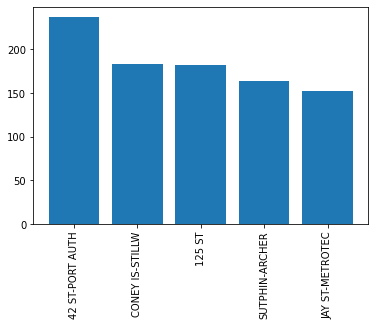

In [717]:
#TOP 5 STATIOINS WHERE MOST FARE EVASION CRIMES HAPPEN
plt.bar(x=ARRESTASSIGNED_STATIONS['STATION'][:5], height=ARRESTASSIGNED_STATIONS['NO_OF_CRIMES'][:5])
plt.xticks(rotation=90)
plt.savefig('graph0909.png')


In [90]:
ARRESTASSIGNED_STATIONS['STATION'].head().to_frame()

,STATION
0,42nd St - Port Authority Bus Term
1,Coney Island - Stillwell Av
2,125th St
3,Sutphin Blvd - Archer Av
4,Jay St - MetroTech


In [91]:
pd.set_option('display.max_rows', df.shape[0]+1)

In [411]:
ARRESTASSIGNED_STATIONS.head()

,STATION,NO_OF_CRIMES
0,42 ST-PORT AUTH,237
1,CONEY IS-STILLW,183
2,125 ST,182
3,SUTPHIN-ARCHER,164
4,JAY ST-METROTEC,152


In [412]:
STATION_TOTALS.head()

,STATION,DAILY_ENTRIES
0,34 ST-PENN STA,48202266.0
1,GRD CNTRL-42 ST,37224737.0
2,FULTON ST,29817826.0
3,23 ST,29772677.0
4,PATH NEW WTC,29056032.0


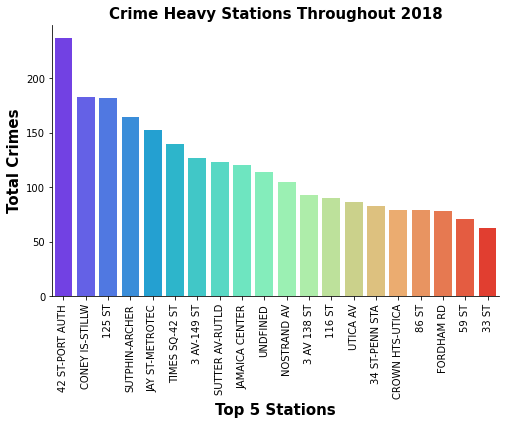

In [700]:
plt.figure(figsize=[8,5])
ax = sns.barplot(data=ARRESTASSIGNED_STATIONS.head(20).reset_index(),x='STATION',y='NO_OF_CRIMES',palette='rainbow')
plt.xlabel('Top 5 Stations',weight='bold',fontsize=15)
plt.ylabel('Total Crimes',weight='bold',fontsize=15)
plt.title('Crime Heavy Stations Throughout 2018', weight='bold',fontsize='15')
plt.xticks(rotation=90)
sns.despine()
plt.savefig('graph9.png')

In [358]:
ARRESTASSIGNED_STATIONS.head(5)

,STATION,NO_OF_CRIMES
0,42 ST-PORT AUTH,237
1,CONEY IS-STILLW,183
2,125 ST,182
3,SUTPHIN-ARCHER,164
4,JAY ST-METROTEC,152


In [170]:
#STATION_TOTALS.sort_values(by= "STATION",ascending=False)

In [127]:
STATION21=STATION_TOTALS[['STATION','DAILY_ENTRIES']].head(21)
STATION21

,STATION,DAILY_ENTRIES
0,34 ST-PENN STA,48202266.0
1,GRD CNTRL-42 ST,37224737.0
2,FULTON ST,29817826.0
3,23 ST,29772677.0
4,PATH NEW WTC,29056032.0
5,34 ST-HERALD SQ,28137875.0
6,14 ST-UNION SQ,27417810.0
7,TIMES SQ-42 ST,24144032.0
8,42 ST-PORT AUTH,20346392.0
9,59 ST,20019711.0


In [719]:
DF_CRIMES_IN_STATIONS=pd.merge(MASK3,STATION_TOTALS,on='STATION')
DF_CRIMES_IN_STATIONS.head(10)

,ARREST_DATE,ARREST__BORO,AGE_GROUP,PERP_SEX,PERP_RACE,STATION,notes,NO_OF_CRIMES,DAILY_ENTRIES
0,2018-12-28,M,25-44,M,WHITE HISPANIC,UNION ST,L-all times,15,2082203.0
1,2018-12-27,M,25-44,M,WHITE,UNION ST,L-all times,15,2082203.0
2,2018-10-27,M,25-44,M,WHITE HISPANIC,UNION ST,L-all times,15,2082203.0
3,2018-10-18,M,45-64,M,WHITE,UNION ST,"N,Q-all times, R-all times exc nights",15,2082203.0
4,2018-08-31,M,18-24,F,WHITE HISPANIC,UNION ST,L-all times,15,2082203.0
5,2018-08-31,M,45-64,M,WHITE HISPANIC,UNION ST,L-all times,15,2082203.0
6,2018-08-29,M,25-44,M,WHITE,UNION ST,L-all times,15,2082203.0
7,2018-08-05,M,18-24,M,WHITE HISPANIC,UNION ST,L-all times,15,2082203.0
8,2018-07-29,M,18-24,M,ASIAN / PACIFIC ISLANDER,UNION ST,L-all times,15,2082203.0
9,2018-07-22,M,25-44,M,BLACK,UNION ST,L-all times,15,2082203.0


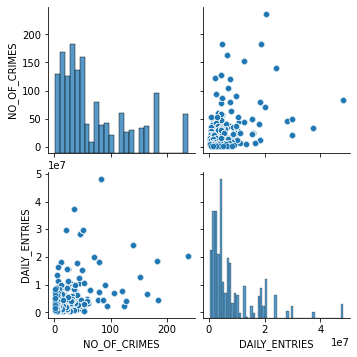

In [699]:
sns.pairplot(DF_CRIMES_IN_STATIONS);
plt.savefig('graph8.png')

In [500]:
DF_STATIONS_CRIMES_SUBSET = DF_CRIMES_IN_STATIONS.loc[:, ['NO_OF_CRIMES','DAILY_ENTRIES']]

In [501]:
DF_STATIONS_CRIMES_SUBSET_COV = pd.DataFrame(np.cov(DF_STATIONS_CRIMES_SUBSET.T)) # cov function calculates row based covariances by default, but we want column covariances
DF_STATIONS_CRIMES_SUBSET_COV.columns = ['NO_OF_CRIMES','DAILY_ENTRIES']
DF_STATIONS_CRIMES_SUBSET_COV.index = ['NO_OF_CRIMES','DAILY_ENTRIES']
DF_STATIONS_CRIMES_SUBSET_COV

,NO_OF_CRIMES,DAILY_ENTRIES
NO_OF_CRIMES,3.911808e+03,2.116073e+08
DAILY_ENTRIES,2.116073e+08,7.564115e+13


In [502]:
DF_STATIONS_CRIMES_SUBSET.var(axis = 0)

NO_OF_CRIMES     3.911808e+03
DAILY_ENTRIES    7.564115e+13
dtype: float64

In [503]:
DF_STATIONS_CRIMES_SUBSET_CORR = pd.DataFrame(np.corrcoef(DF_STATIONS_CRIMES_SUBSET.T)) # corrcoef function calculates row based correlations by default, but we want column correlations
DF_STATIONS_CRIMES_SUBSET_CORR.columns = ['NO_OF_CRIMES','DAILY_ENTRIES']
DF_STATIONS_CRIMES_SUBSET_CORR.index = ['NO_OF_CRIMES','DAILY_ENTRIES']
DF_STATIONS_CRIMES_SUBSET_CORR

,NO_OF_CRIMES,DAILY_ENTRIES
NO_OF_CRIMES,1.000000,0.389012
DAILY_ENTRIES,0.389012,1.000000


In [504]:
NOOFCRIMES_NORM = (DF_STATIONS_CRIMES_SUBSET['NO_OF_CRIMES']-np.mean(DF_STATIONS_CRIMES_SUBSET['NO_OF_CRIMES']))/np.std(DF_STATIONS_CRIMES_SUBSET['NO_OF_CRIMES'])
DAILYENTRIES_NORM = (DF_STATIONS_CRIMES_SUBSET['DAILY_ENTRIES']-np.mean(DF_STATIONS_CRIMES_SUBSET['DAILY_ENTRIES']))/np.std(DF_STATIONS_CRIMES_SUBSET['DAILY_ENTRIES'])

Text(0, 0.5, 'Normalized Daily Entries')

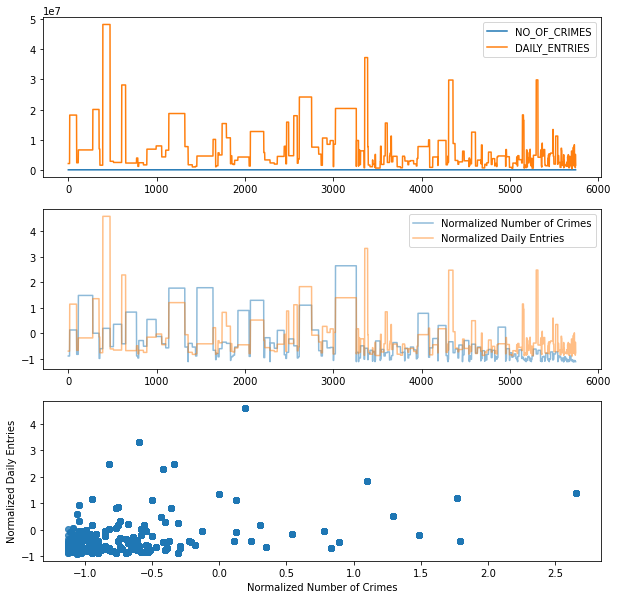

In [505]:
plt.figure(figsize=[10,10])
plt.subplot(3,1,1)
plt.plot(DF_STATIONS_CRIMES_SUBSET['NO_OF_CRIMES'])
plt.plot(DF_STATIONS_CRIMES_SUBSET['DAILY_ENTRIES'])
plt.legend(['NO_OF_CRIMES','DAILY_ENTRIES'])
plt.subplot(3,1,2)
plt.plot(NOOFCRIMES_NORM,alpha = 0.5)
plt.plot(DAILYENTRIES_NORM,alpha = 0.5)
plt.legend(['Normalized Number of Crimes','Normalized Daily Entries'])
plt.subplot(3,1,3)
plt.scatter(NOOFCRIMES_NORM,DAILYENTRIES_NORM,alpha = 0.8)
plt.xlabel('Normalized Number of Crimes')
plt.ylabel('Normalized Daily Entries')
plt.savefig('graph7.png')

<AxesSubplot:>

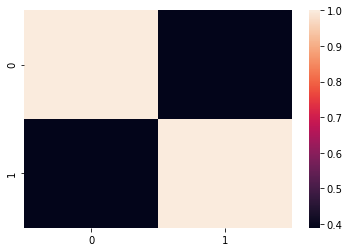

In [506]:
sns.heatmap(np.corrcoef(DF_STATIONS_CRIMES_SUBSET.T))

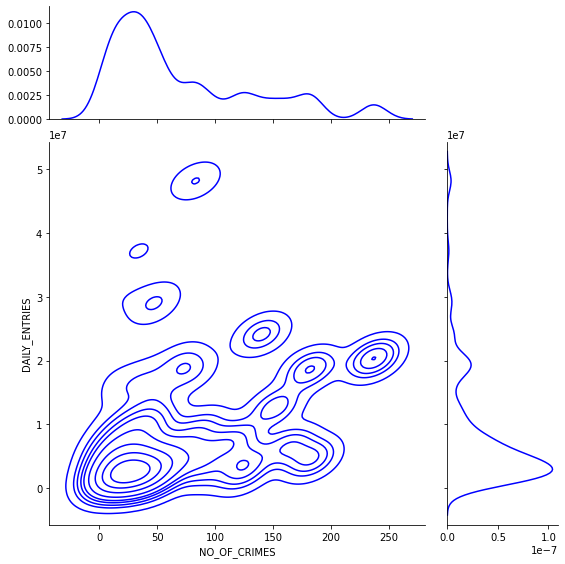

In [698]:
sns.jointplot(x="NO_OF_CRIMES", y="DAILY_ENTRIES", kind="kde",dropna = True ,color='b',height=8, ratio=3, marginal_ticks=True, data=DF_CRIMES_IN_STATIONS);
plt.savefig('graph6.png')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnin

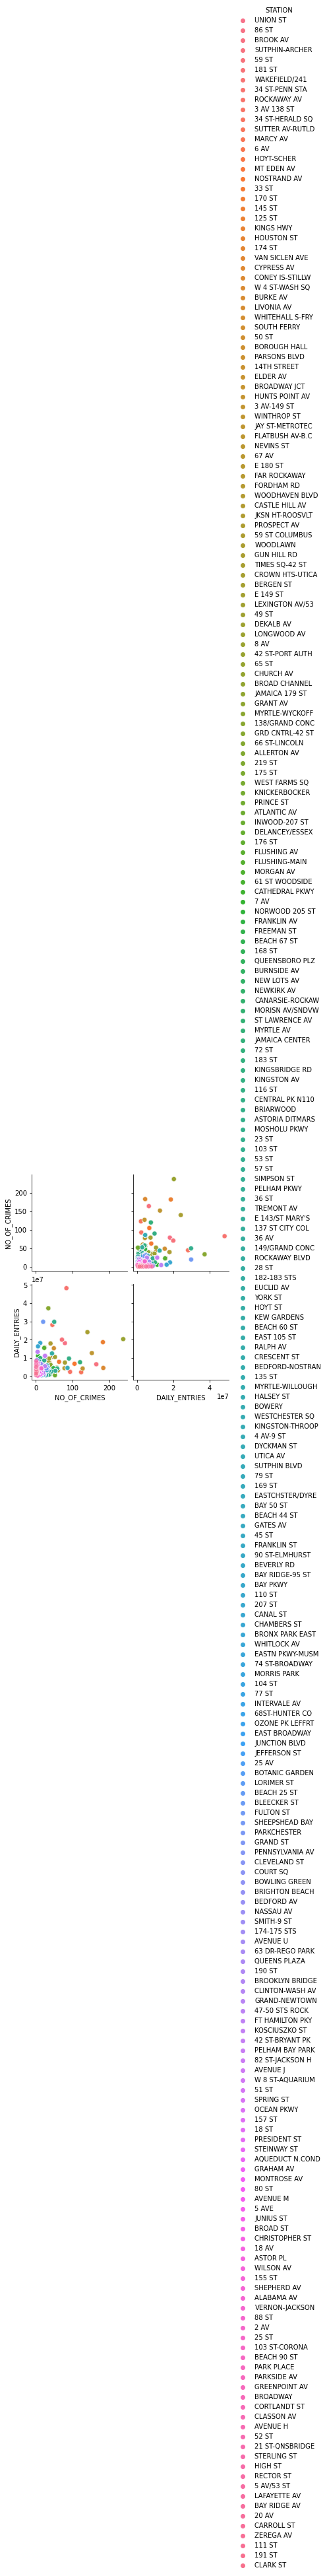

In [507]:
sns.pairplot(DF_CRIMES_IN_STATIONS,hue='STATION',plot_kws={'alpha':0.7,'s':50},diag_kind='kde')

In [508]:
AVGOFENTRIES = DF_CRIMES_IN_STATIONS.groupby(by = ['STATION']).mean()# avg of entries and exits to each stations to plot the heatmap
AVGOFENTRIES5=AVGOFENTRIES.head(5)

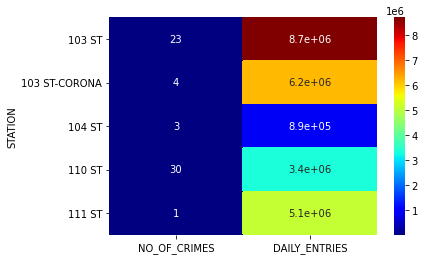

In [697]:
sns.heatmap(AVGOFENTRIES5,cmap='jet',annot=True);
plt.savefig('graph5.png')

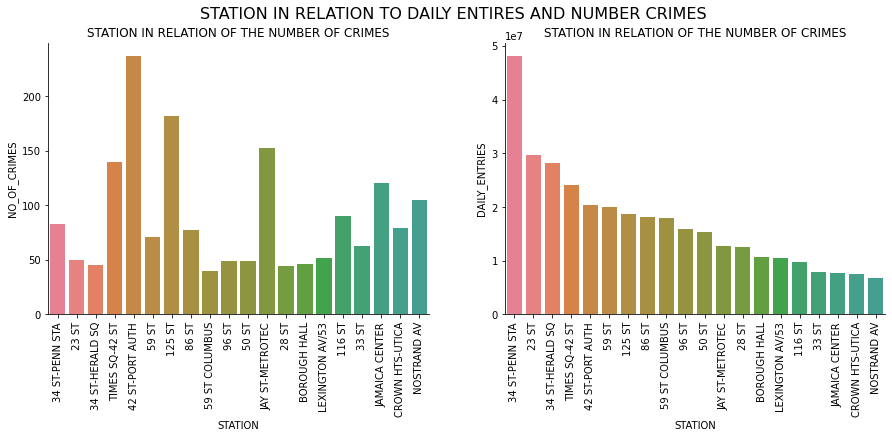

In [211]:
plt.figure(figsize=[15,5])
plt.suptitle('STATION IN RELATION TO DAILY ENTIRES AND NUMBER CRIMES',fontsize = 16)#main title

plt.subplot(1,2,1) # (number of rows, number of columns, number of plot)
sns.barplot(x = DF_STATIONS_CRIMES['STATION'].head(20),y='NO_OF_CRIMES',data=DF_STATIONS_CRIMES,palette = sns.color_palette("husl", 40));
sns.despine()
plt.xticks(rotation=90)
plt.title('STATION IN RELATION OF THE NUMBER OF CRIMES')

plt.subplot(1,2,2)
sns.barplot(x = DF_STATIONS_CRIMES['STATION'].head(20),y='DAILY_ENTRIES',data=DF_STATIONS_CRIMES,palette = sns.color_palette("husl", 40));
sns.despine()
plt.xticks(rotation=90)
plt.title('STATION IN RELATION OF THE NUMBER OF CRIMES');

In [525]:
engine=create_engine('sqlite://',echo=False)

In [526]:
DF_CRIMES_IN_STATIONS.to_sql('DF_CS',con=engine)

In [532]:
CRIMESGROUPBYSTATION=pd.read_sql('select * from DF_CS group by STATION order by NO_OF_CRIMES DESC',engine)
CRIMESGROUPBYSTATION

,index,ARREST_DATE,ARREST__BORO,AGE_GROUP,PERP_SEX,PERP_RACE,STATION,notes,NO_OF_CRIMES,DAILY_ENTRIES
0,3023,2018-12-12,M,18-24,M,BLACK HISPANIC,42 ST-PORT AUTH,"A,E-all times, C-all times exc nights",237,20346392.0
1,1455,2018-12-21,K,25-44,M,BLACK,CONEY IS-STILLW,"D,F,N,Q-all times",183,4576933.0
2,1137,2018-12-22,M,18-24,F,BLACK,125 ST,"A,D-all times, B-weekdays and evenings, C-all ...",182,18670053.0
3,113,2018-12-28,Q,45-64,F,BLACK,SUTPHIN-ARCHER,"E,J-all times, Z-rush hours AM westbound, PM e...",164,6596330.0
4,2060,2018-12-18,K,45-64,M,WHITE,JAY ST-METROTEC,"A,F-all times, C-all times exc nights",152,12703786.0
5,2614,2018-12-15,M,18-24,M,WHITE HISPANIC,TIMES SQ-42 ST,"S to Grand Central-all times exc nights, close...",140,24144032.0
6,1919,2018-12-18,B,18-24,M,BLACK,3 AV-149 ST,"2-all times, 5-all times exc nights",127,4241094.0
7,649,2018-12-23,K,25-44,M,BLACK,SUTTER AV-RUTLD,L-all times,123,2247135.0
8,3957,2018-12-01,Q,45-64,M,BLACK,JAMAICA CENTER,"E,J-all times, Z-rush hours AM westbound, PM e...",120,7717198.0
9,889,2018-12-22,K,25-44,M,WHITE HISPANIC,NOSTRAND AV,"A-all times, C-all times exc nights",105,6852258.0


In [614]:
CRIMESGROUPBYSTATION5=pd.read_sql('select * from DF_CS group by STATION order by NO_OF_CRIMES DESC limit 5',engine)
CRIMESGROUPBYSTATION5

,index,ARREST_DATE,ARREST__BORO,AGE_GROUP,PERP_SEX,PERP_RACE,STATION,notes,NO_OF_CRIMES,DAILY_ENTRIES
0,3023,2018-12-12,M,18-24,M,BLACK HISPANIC,42 ST-PORT AUTH,"A,E-all times, C-all times exc nights",237,20346392.0
1,1455,2018-12-21,K,25-44,M,BLACK,CONEY IS-STILLW,"D,F,N,Q-all times",183,4576933.0
2,1137,2018-12-22,M,18-24,F,BLACK,125 ST,"A,D-all times, B-weekdays and evenings, C-all ...",182,18670053.0
3,113,2018-12-28,Q,45-64,F,BLACK,SUTPHIN-ARCHER,"E,J-all times, Z-rush hours AM westbound, PM e...",164,6596330.0
4,2060,2018-12-18,K,45-64,M,WHITE,JAY ST-METROTEC,"A,F-all times, C-all times exc nights",152,12703786.0


In [533]:
CRIMESGROUPBYSTATION = CRIMESGROUPBYSTATION.drop(['index'], axis=1, errors="ignore")
CRIMESGROUPBYSTATION

,ARREST_DATE,ARREST__BORO,AGE_GROUP,PERP_SEX,PERP_RACE,STATION,notes,NO_OF_CRIMES,DAILY_ENTRIES
0,2018-12-12,M,18-24,M,BLACK HISPANIC,42 ST-PORT AUTH,"A,E-all times, C-all times exc nights",237,20346392.0
1,2018-12-21,K,25-44,M,BLACK,CONEY IS-STILLW,"D,F,N,Q-all times",183,4576933.0
2,2018-12-22,M,18-24,F,BLACK,125 ST,"A,D-all times, B-weekdays and evenings, C-all ...",182,18670053.0
3,2018-12-28,Q,45-64,F,BLACK,SUTPHIN-ARCHER,"E,J-all times, Z-rush hours AM westbound, PM e...",164,6596330.0
4,2018-12-18,K,45-64,M,WHITE,JAY ST-METROTEC,"A,F-all times, C-all times exc nights",152,12703786.0
5,2018-12-15,M,18-24,M,WHITE HISPANIC,TIMES SQ-42 ST,"S to Grand Central-all times exc nights, close...",140,24144032.0
6,2018-12-18,B,18-24,M,BLACK,3 AV-149 ST,"2-all times, 5-all times exc nights",127,4241094.0
7,2018-12-23,K,25-44,M,BLACK,SUTTER AV-RUTLD,L-all times,123,2247135.0
8,2018-12-01,Q,45-64,M,BLACK,JAMAICA CENTER,"E,J-all times, Z-rush hours AM westbound, PM e...",120,7717198.0
9,2018-12-22,K,25-44,M,WHITE HISPANIC,NOSTRAND AV,"A-all times, C-all times exc nights",105,6852258.0


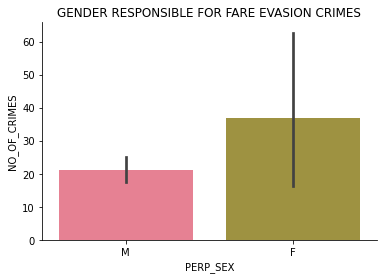

In [696]:
sns.barplot(x = 'PERP_SEX',y='NO_OF_CRIMES',data=CRIMESGROUPBYSTATION,palette = sns.color_palette("husl", 5));
sns.despine()
plt.title('GENDER RESPONSIBLE FOR FARE EVASION CRIMES');
plt.savefig('graph4.png')

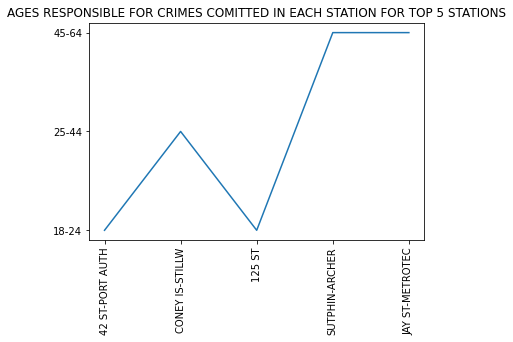

In [695]:
plt.plot(CRIMESGROUPBYSTATION5['STATION'],CRIMESGROUPBYSTATION5['AGE_GROUP']);
plt.xticks(rotation=90)
plt.title('AGES RESPONSIBLE FOR CRIMES COMITTED IN EACH STATION FOR TOP 5 STATIONS');
plt.savefig('graph3.png')

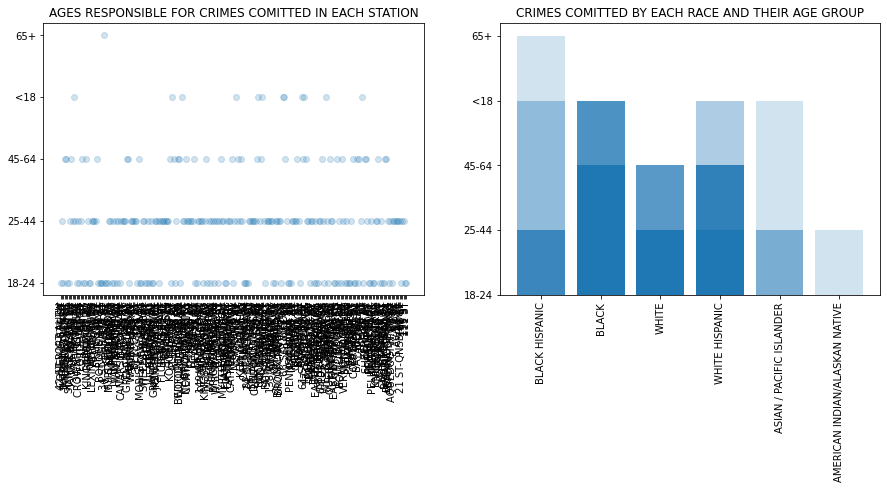

In [694]:

plt.figure(figsize=[15,5])

plt.subplot(1,2,1)
plt.scatter(CRIMESGROUPBYSTATION['STATION'],CRIMESGROUPBYSTATION['AGE_GROUP'],alpha = 0.2);
plt.xticks(rotation=90)
plt.title('AGES RESPONSIBLE FOR CRIMES COMITTED IN EACH STATION');

plt.subplot(1,2,2)
plt.bar(CRIMESGROUPBYSTATION['PERP_RACE'],CRIMESGROUPBYSTATION['AGE_GROUP'],alpha = 0.2);
plt.xticks(rotation=90)
plt.title('CRIMES COMITTED BY EACH RACE AND THEIR AGE GROUP');

plt.savefig('graph2.png')

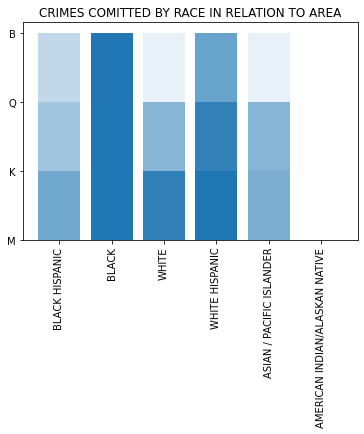

In [693]:
plt.bar(CRIMESGROUPBYSTATION['PERP_RACE'],CRIMESGROUPBYSTATION['ARREST__BORO'],alpha = 0.1);
plt.xticks(rotation=90)
plt.title('CRIMES COMITTED BY RACE IN RELATION TO AREA');
plt.savefig('graph1.png')